In [446]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline

#### Загрузка, проверка и очистка данных

##### AB Test Hit

In [2]:
# загрузка данных
ab = pd.read_csv('AB Test Hit.csv', parse_dates=['hit_at'])

ab

,hit_at,anonymous_id,group,device_type,browser,os
0,2020-11-30 04:21:38.616000+00:00,3e05a2dc-3922-4caf-b837-08fcb337c82e,default,desktop,IE,Windows
1,2020-12-01 20:24:04.363000+00:00,7f00b6ca-7938-4866-a323-c520838f5ef9,default,desktop,IE,Windows
2,2020-11-28 20:16:52.901000+00:00,91e9900e-2cc6-4362-92b4-9e6712a6918e,address_first,desktop,IE,Windows
3,2020-11-29 13:29:40.557000+00:00,616dd5e8-dee2-47aa-9d80-0dfadcf1922f,default,desktop,IE,Windows
4,2020-11-27 14:56:29.471000+00:00,64734da4-d9f3-4d53-b401-4d0819a6e5fb,default,desktop,IE,Windows
...,...,...,...,...,...,...
502779,2020-12-10 21:21:23.679000+00:00,fb2764ef-5492-4dd0-b35f-f3a600b54168,default,tablet,Samsung Browser,Android
502780,2020-12-10 22:41:08.845000+00:00,3b3edc2b-8627-467a-8188-99f781551f2a,default,mobile,Samsung Browser,Android
502781,2020-12-02 01:51:27.209000+00:00,d58bc44a-b7cc-4156-b04b-bb8c8131ec77,default,desktop,Avast Secure Browser,Windows
502782,2020-12-05 09:43:06.159000+00:00,5b996a40-a41c-4d09-b7cb-e82c33f11cff,default,desktop,Avast Secure Browser,Windows


In [3]:
# общая информация о типе данных и пропущенных значениях
ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502784 entries, 0 to 502783
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   hit_at        502784 non-null  datetime64[ns, UTC]
 1   anonymous_id  502784 non-null  object             
 2   group         502784 non-null  object             
 3   device_type   502784 non-null  object             
 4   browser       502784 non-null  object             
 5   os            502783 non-null  object             
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 23.0+ MB


In [4]:
# найдем пользователей, которые попали и в тестовую и в контрольную группы
bad_ids = ab.groupby('anonymous_id', as_index=False) \
    .agg({'group': 'nunique'}) \
    .sort_values('group', ascending=False) \
    .query('group == 2').anonymous_id.to_list()

bad_ids

['9c896180-4a29-49fa-b2f2-5406608f699b',
 'a15f4465-40ed-43fd-9955-ea329e7af1d2',
 'c8b733d8-e0d6-4681-ab20-5a9131f93440',
 'dee73519-5e29-4073-a488-5140cafeb9b9',
 '837b463c-1731-4a0c-99a5-9abcc9d168c2',
 '0dc440a8-7e54-4fdf-883f-54d8dd9ec87a',
 '916090a7-3abc-4fc0-befe-4bb5fb4acce2',
 '8da9dfd0-7b70-4e98-a689-e89655e66684',
 '7dba40aa-4d15-41a3-bd85-ebfcddf09432',
 '2126f677-4f23-42a8-978a-08d51d9f770c',
 'b6b299e7-68f4-4acf-9084-d5113885b964',
 'a29ad181-c95e-442d-91e7-2c420f3b6fef',
 'fe07d909-ca54-42fd-a140-cf36884acf15',
 '2bedc3ea-34f0-4cb1-99d2-b63034140c6e',
 '056d91e7-3bc5-4e12-98d2-fc4e2403ff34',
 '7e2c2b79-9537-415e-9a9e-aa388f0877f1',
 '6eae3eb4-6dad-4d80-8ffd-149815624ffc',
 '76d6db8b-b413-4dc6-8110-221ab86fdd94',
 '39e51735-b37c-42ef-9e0d-84265767a6db',
 'de2c38be-6de4-4472-a506-1a634e3cc131',
 '81164caa-47b6-42a8-9752-c2c415915d5e',
 '370d8efa-9192-4202-a1b1-27c09cf5733e',
 'e608eaa7-f78d-4452-929d-2a48c0ac71ca',
 '43d1db46-c185-4699-b3fc-3ed6e2560b00',
 '3081890f-59fa-

In [5]:
# количество таких пользователей
len(bad_ids)

528

In [6]:
# проверка вхождения пользователя в обе группы
ab[ab['anonymous_id'] == '9c896180-4a29-49fa-b2f2-5406608f699b']

,hit_at,anonymous_id,group,device_type,browser,os
469753,2020-12-06 13:14:26.983000+00:00,9c896180-4a29-49fa-b2f2-5406608f699b,default,mobile,Chrome WebView,Android
479923,2020-12-06 13:14:26.998000+00:00,9c896180-4a29-49fa-b2f2-5406608f699b,address_first,mobile,Chrome WebView,Android


In [7]:
# удалим таких пользователей из датасета
ab = ab.query('anonymous_id not in @bad_ids')

In [8]:
# поиск и удаление дубликатов одновременно по времени и по id пользователя
def rem_duplicated(df, timestamp):
    ids = df[df[timestamp].duplicated() == True][timestamp].to_list()
    
    dupl_ts = []
    for ts in ids:
        if df.query('hit_at == @ts').anonymous_id.nunique() == 1:
            dupl_ts.append(ts)
    
    count = 0
    for ts in dupl_ts:
        if len(df.query('hit_at == @ts')) > 0:
            idx = df.query('hit_at == @ts').index
            for i in idx[1:]:
                df = df.drop(index=i)
                count += 1
            #dupl_ts.remove(ts)
    print(f'{count} duplicates were removed.')
    return df

ab = rem_duplicated(ab, 'hit_at')

0 duplicates were removed.


In [96]:
# проверка id пользователей на попадание в группу несколько раз
ab[ab.anonymous_id.duplicated(keep=False) == True] \
    .groupby('anonymous_id') \
    .agg({'hit_at': 'count'}) \
    .sort_values('hit_at', ascending=False) \
    .rename(columns={'hit_at': 'hit_at_cnt'})

,hit_at_cnt
anonymous_id,
5bb785fd-e0e7-447a-b0e1-a06328b31cbe,18
1dea1cc9-72c0-4bee-bdb6-c59faacd72ba,15
06eaec3d-511a-4794-92ea-a19efaaf7f19,15
bcaa113d-c128-443f-9ede-2736847e1969,15
ba5239f5-1115-4caa-aef2-242a9c039b12,14
...,...
5c6a61ea-a507-40e2-8424-f6ef7df3bb2d,2
5c6c45b8-657c-417c-811a-d59b997a8990,2
5c71a65c-4bba-4ade-8914-f60d892f6800,2


In [106]:
# удаление повторных попаданий id пользователей в одну из групп несколько раз
ab = ab.sort_values('hit_at', ascending=True)\
    .drop_duplicates(subset=['anonymous_id'], keep='first')

##### Landing Viewed

In [9]:
# загрузка данных
landing_v = pd.read_csv('Landing Viewed.csv', parse_dates=['timestamp'])

landing_v

,timestamp,anonymous_id
0,2020-12-05 10:01:51.305000+00:00,00001104-4c72-4f48-bb8c-ace2ded63f8b
1,2020-12-08 11:07:39.962000+00:00,00007575-88d6-4acc-9940-e9ccb8358dca
2,2020-12-03 13:12:37.952000+00:00,00016e45-138b-401e-9eac-78b92d48c6c4
3,2020-12-02 16:03:37.548000+00:00,0001814e-5cf7-4d23-bc95-4630d9152fc1
4,2020-12-01 08:24:51.787000+00:00,00021d91-c65e-4049-9ae1-7d64702c8c12
...,...,...
341476,2020-12-05 14:54:01.768000+00:00,fffedf6a-7be6-4313-a0d9-ff87463ba6e8
341477,2020-12-10 10:47:30.204000+00:00,fffee334-8e5d-4923-b97e-c3ebb060d70b
341478,2020-12-04 19:15:55.857000+00:00,fffee334-8e5d-4923-b97e-c3ebb060d70b
341479,2020-12-07 06:11:38.610000+00:00,ffff53e1-df50-43dd-a1d3-c2e34271920b


In [13]:
# общая информация о типе данных и пропущенных значениях
landing_v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341481 entries, 0 to 341480
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   timestamp     341481 non-null  datetime64[ns, UTC]
 1   anonymous_id  341481 non-null  object             
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 5.2+ MB


In [14]:
# поиск и удаление дубликатов одновременно по времени и по id пользователя
def rem_duplicated(df, timestamp):
    ids = df[df[timestamp].duplicated() == True][timestamp].to_list()
    
    dupl_ts = []
    for ts in ids:
        if df.query('timestamp == @ts').anonymous_id.nunique() == 1:
            dupl_ts.append(ts)
    
    count = 0
    for ts in dupl_ts:
        if len(df.query('timestamp == @ts')) > 0:
            idx = df.query('timestamp == @ts').index
            for i in idx[1:]:
                df = df.drop(index=i)
                count += 1
            #dupl_ts.remove(ts)
    print(f'{count} duplicates were removed.')
    return df

landing_v = rem_duplicated(landing_v, 'timestamp')

116 duplicates were removed.


##### Main Page Viewed

In [15]:
# загрузка данных
main_page_v = pd.read_csv('Main Page Viewed.csv', parse_dates=['timestamp'])

main_page_v

,timestamp,anonymous_id,retailer_id
0,2020-11-29 08:54:57.640000+00:00,00000782-154a-4159-ab12-6c34b658e375,1
1,2020-11-29 08:22:54.554000+00:00,00000782-154a-4159-ab12-6c34b658e375,1
2,2020-11-30 10:56:52.877000+00:00,00000782-154a-4159-ab12-6c34b658e375,1
3,2020-11-29 08:22:24.663000+00:00,00000782-154a-4159-ab12-6c34b658e375,1
4,2020-11-29 09:07:11.648000+00:00,00000782-154a-4159-ab12-6c34b658e375,1
...,...,...,...
613504,2020-11-26 09:53:21.894000+00:00,f62072ba-c666-4592-b2d5-627eafd445cd,253
613505,2020-12-01 15:47:22.935000+00:00,f7195120-87dc-404d-a31c-afcfad71cc35,253
613506,2020-11-28 17:03:38.479000+00:00,f84d997a-ce87-4e88-bf67-c2b1c50b71eb,253
613507,2020-11-29 13:38:47.575000+00:00,fa1f6122-363e-4264-a92d-701a6fe44161,253


In [16]:
# общая информация о типе данных и пропущенных значениях
main_page_v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613509 entries, 0 to 613508
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   timestamp     613509 non-null  datetime64[ns, UTC]
 1   anonymous_id  613509 non-null  object             
 2   retailer_id   613509 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 14.0+ MB


In [17]:
# поиск и удаление дубликатов одновременно по времени и по id пользователя
main_page_v = rem_duplicated(main_page_v, 'timestamp')

201 duplicates were removed.


##### Address Change Initiated

In [18]:
# загрузка данных
address_c = pd.read_csv('Address Change Initiated.csv', parse_dates=['timestamp'])

address_c

,timestamp,anonymous_id,source
0,2020-12-17 16:52:48.751000+00:00,01005c8a-9fae-463e-89de-c96ba54b33d5,add_alcohol
1,2020-12-07 19:47:02.284000+00:00,033b1952-ff45-48ff-b26f-6cdb78d549a2,add_alcohol
2,2020-12-16 06:54:25.958000+00:00,03fc2ae5-318f-4292-b1c8-68e59923cd4f,add_alcohol
3,2020-12-10 18:27:01.658000+00:00,045a73a6-49cf-430a-81ba-80d0062d8bea,add_alcohol
4,2020-12-09 08:47:39.586000+00:00,06bf46cd-3aa9-4526-8ad8-889b7dabbdfd,add_alcohol
...,...,...,...
103429,2020-12-07 11:44:04.057000+00:00,ff4aa09d-3dff-4081-af72-92674f13dd16,not_in_delivery_zone
103430,2020-12-10 21:14:34.090000+00:00,ff963d29-a47b-48b6-ae2c-95c9a493e281,not_in_delivery_zone
103431,2020-12-10 21:13:55.326000+00:00,ff963d29-a47b-48b6-ae2c-95c9a493e281,not_in_delivery_zone
103432,2020-12-17 18:48:55.322000+00:00,ffa28c7d-2f59-4db9-a44f-9b09a1d5e457,not_in_delivery_zone


In [19]:
# общая информация о типе данных и пропущенных значениях
address_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103434 entries, 0 to 103433
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   timestamp     103434 non-null  datetime64[ns, UTC]
 1   anonymous_id  103434 non-null  object             
 2   source        103434 non-null  object             
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 2.4+ MB


In [20]:
# поиск и удаление дубликатов одновременно по времени и по id пользователя
address_c = rem_duplicated(address_c, 'timestamp')

64 duplicates were removed.


##### Address not in delivery zone

In [21]:
# загрузка данных
address_not = pd.read_csv('Address Not In Delivery Zone.csv', parse_dates=['timestamp'])

address_not

,timestamp,anonymous_id
0,2020-11-29 18:23:55.997000+00:00,000dece9-6e24-4ea0-861e-3d71a055fc37
1,2020-12-05 04:15:49.615000+00:00,000fe246-60f5-4b91-b26b-6dd10760d565
2,2020-12-05 12:13:05.248000+00:00,0037b3e8-2a0e-4e86-a0a1-b3dd1d06501c
3,2020-12-05 12:04:23.065000+00:00,0037b3e8-2a0e-4e86-a0a1-b3dd1d06501c
4,2020-12-05 12:06:42.038000+00:00,0037b3e8-2a0e-4e86-a0a1-b3dd1d06501c
...,...,...
6162,2020-12-17 18:47:06.933000+00:00,ffa28c7d-2f59-4db9-a44f-9b09a1d5e457
6163,2020-11-30 06:21:44.788000+00:00,ffa8d479-2db4-4a55-a3c2-710bdbb581ec
6164,2020-11-30 06:21:48.006000+00:00,ffa8d479-2db4-4a55-a3c2-710bdbb581ec
6165,2020-12-08 08:28:04.215000+00:00,ffc3b5ac-d880-408c-8f3c-2d01a87a301c


In [22]:
# общая информация о типе данных и пропущенных значениях
address_not.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6167 entries, 0 to 6166
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   timestamp     6167 non-null   datetime64[ns, UTC]
 1   anonymous_id  6167 non-null   object             
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 96.5+ KB


In [23]:
# поиск дубликатов по времени
address_not[address_not.timestamp.duplicated() == True]  # дубликаты не были найдены

,timestamp,anonymous_id


##### Shop Selection Started

In [24]:
# загрузка данных
selection_started = pd.read_csv('Shop Celection Started.csv', parse_dates=['timestamp'])

selection_started

,timestamp,anonymous_id,source
0,2020-12-01 09:49:12.615000+00:00,1da378e1-ad44-48d6-8002-f39c59b3e21e,header
1,2020-12-01 03:17:26.084000+00:00,a182785b-5da1-4445-92a6-c6ddafcc65df,header
2,2020-12-01 03:16:11.650000+00:00,a182785b-5da1-4445-92a6-c6ddafcc65df,header
3,2020-12-01 03:15:10.845000+00:00,a182785b-5da1-4445-92a6-c6ddafcc65df,header
4,2020-12-01 03:16:54.069000+00:00,a182785b-5da1-4445-92a6-c6ddafcc65df,header
...,...,...,...
57402,2020-12-08 17:10:05.072000+00:00,165d6f58-ba87-4c0a-99fe-e6c9693b39a5,address_modal
57403,2020-12-08 17:05:28.783000+00:00,165d6f58-ba87-4c0a-99fe-e6c9693b39a5,address_modal
57404,2020-12-08 17:02:42.966000+00:00,165d6f58-ba87-4c0a-99fe-e6c9693b39a5,address_modal
57405,2020-12-08 17:09:14.421000+00:00,165d6f58-ba87-4c0a-99fe-e6c9693b39a5,address_modal


In [25]:
# общая информация о типе данных и пропущенных значениях
selection_started.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57407 entries, 0 to 57406
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   timestamp     57407 non-null  datetime64[ns, UTC]
 1   anonymous_id  57407 non-null  object             
 2   source        57407 non-null  object             
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 1.3+ MB


In [26]:
# поиск и удаление дубликатов одновременно по времени и по id пользователя
selection_started = rem_duplicated(selection_started, 'timestamp')

2 duplicates were removed.


##### Shop Selected

In [27]:
# загрузка данных
shop_selected = pd.read_csv('Shop Selected.csv', parse_dates=['timestamp'])

shop_selected

,timestamp,anonymous_id,source
0,2020-11-30 17:33:43.161000+00:00,bc5ea2f8-fd4c-4f85-a0cb-f777bf87b82c,address_modal
1,2020-11-30 16:38:32.893000+00:00,2462f92f-e1f5-49cb-8174-ea938d210fd3,header
2,2020-11-30 17:25:06.712000+00:00,290c7999-8392-41f8-ab31-e208fe65bd82,header
3,2020-11-30 04:55:43.421000+00:00,15975d1c-3b06-46a5-b2f3-a393cc0be2ee,header
4,2020-11-30 04:55:43.430000+00:00,15975d1c-3b06-46a5-b2f3-a393cc0be2ee,header
...,...,...,...
211723,2020-12-06 20:37:45.220000+00:00,95e07e4a-65c1-4387-9851-56a1427e61f5,header
211724,2020-12-06 16:16:54.724000+00:00,30e33171-1624-499d-a77e-b9acf211c5ff,header
211725,2020-12-06 04:52:59.598000+00:00,ab9689cc-adbf-47e1-bc40-61a7181a4016,header
211726,2020-12-06 04:52:59.416000+00:00,ab9689cc-adbf-47e1-bc40-61a7181a4016,header


In [28]:
# общая информация о типе данных и пропущенных значениях
shop_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211728 entries, 0 to 211727
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   timestamp     211728 non-null  datetime64[ns, UTC]
 1   anonymous_id  211728 non-null  object             
 2   source        211728 non-null  object             
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 4.8+ MB


In [29]:
# поиск и удаление дубликатов одновременно по времени и по id пользователя
shop_selected = rem_duplicated(shop_selected, 'timestamp')

769 duplicates were removed.


##### Add to cart clicked

In [30]:
# загрузка данных
add_clicked = pd.read_csv('Add To Cart Clicked.csv', parse_dates=['timestamp'])

add_clicked

,timestamp,anonymous_id
0,2020-11-30 03:08:30.345000+00:00,04880e58-9530-46c2-bf03-b9bc21e72e99
1,2020-11-30 11:13:52.439000+00:00,74526202-97a7-49d7-b312-91d93583c530
2,2020-11-30 09:11:38.708000+00:00,d246c872-7a1e-4a02-9440-0908ba605f79
3,2020-11-30 09:42:22.833000+00:00,71102afd-bcf1-4585-aaba-819b68554c79
4,2020-11-30 03:38:11.446000+00:00,df194e6d-d88a-4b18-bf44-209992dd9f7e
...,...,...
1223412,2020-11-29 11:24:48.766000+00:00,2ab2ef69-c46d-4a4d-9300-74fe27614813
1223413,2020-11-29 11:22:45.471000+00:00,2ab2ef69-c46d-4a4d-9300-74fe27614813
1223414,2020-11-29 11:16:39.212000+00:00,2ab2ef69-c46d-4a4d-9300-74fe27614813
1223415,2020-11-29 11:19:40.169000+00:00,2ab2ef69-c46d-4a4d-9300-74fe27614813


In [31]:
# общая информация о типе данных и пропущенных значениях
add_clicked.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1223417 entries, 0 to 1223416
Data columns (total 2 columns):
 #   Column        Non-Null Count    Dtype              
---  ------        --------------    -----              
 0   timestamp     1223417 non-null  datetime64[ns, UTC]
 1   anonymous_id  1223417 non-null  object             
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 18.7+ MB


In [32]:
# поиск и удаление дубликатов одновременно по времени и по id пользователя
add_clicked = rem_duplicated(add_clicked, 'timestamp')

157 duplicates were removed.


##### Product Added

In [33]:
# загрузка данных
product_added = pd.read_csv('Product Added.csv', parse_dates=['timestamp'])

product_added

,timestamp,anonymous_id
0,2020-12-09 20:51:32.429000+00:00,e2d50ef1-0667-4da4-88ef-ecbdd7c6a73a
1,2020-12-09 19:39:10.216000+00:00,bb5ca977-97f4-4ec8-8a71-fe206108917b
2,2020-12-09 21:53:08.999000+00:00,8e965f2b-7da0-4efb-84f5-f205956e8c30
3,2020-12-09 19:46:22.307000+00:00,bb5ca977-97f4-4ec8-8a71-fe206108917b
4,2020-12-09 22:16:13.379000+00:00,8e965f2b-7da0-4efb-84f5-f205956e8c30
...,...,...
1150055,2020-12-16 14:02:36.525000+00:00,24e9b637-ec16-47c6-8f47-30c1703582dd
1150056,2020-12-16 13:47:42.788000+00:00,d8f9457c-de6b-49d4-8a1d-e389eb56a29f
1150057,2020-12-16 13:01:23.606000+00:00,d8f9457c-de6b-49d4-8a1d-e389eb56a29f
1150058,2020-12-16 13:50:52.321000+00:00,d8f9457c-de6b-49d4-8a1d-e389eb56a29f


In [34]:
# общая информация о типе данных и пропущенных значениях
product_added.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150060 entries, 0 to 1150059
Data columns (total 2 columns):
 #   Column        Non-Null Count    Dtype              
---  ------        --------------    -----              
 0   timestamp     1150060 non-null  datetime64[ns, UTC]
 1   anonymous_id  1150060 non-null  object             
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 17.5+ MB


In [35]:
# поиск и удаление дубликатов одновременно по времени и по id пользователя
product_added = rem_duplicated(product_added, 'timestamp')

0 duplicates were removed.


##### Order Completed

In [36]:
# загрузка данных
completed = pd.read_csv('Order Completed.csv', parse_dates=['timestamp'])

completed

,timestamp,anonymous_id,order_sum
0,2020-12-10 09:23:09.195000+00:00,3343c486-8d88-44a6-87e5-5c1631e3db3d,3746.231921
1,2020-12-10 13:11:07.166000+00:00,c4491ab9-e59e-444e-bd92-c462830e4b5b,1619.242047
2,2020-12-10 15:42:29.153000+00:00,82f2bac5-8c73-4ed2-8022-27fa0dbd8fc2,2439.605901
3,2020-12-10 17:04:52.163000+00:00,fffb6076-550e-445e-8227-68219671113a,1288.577888
4,2020-12-10 21:25:58.898000+00:00,00e258f1-7908-467e-a66e-d42284ea3f2d,6875.955129
...,...,...,...
16645,2020-12-15 02:15:22.230000+00:00,43e5cc04-046f-445a-8f43-ca8417b6e05a,71476.288670
16646,2020-12-15 11:02:21.910000+00:00,e743a463-8d40-4c19-a97d-7520034114a9,4159.459050
16647,2020-12-15 01:06:20.549000+00:00,89e104ef-6352-4b94-802e-82281044a8be,1492.155679
16648,2020-12-15 17:22:06.893000+00:00,1b7b1c94-4581-4a40-9c23-93214b35411b,1651.523192


In [37]:
# общая информация о типе данных и пропущенных значениях
completed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16650 entries, 0 to 16649
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   timestamp     16650 non-null  datetime64[ns, UTC]
 1   anonymous_id  16650 non-null  object             
 2   order_sum     16650 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 390.4+ KB


In [38]:
# поиск и удаление дубликатов одновременно по времени и по id пользователя
completed = rem_duplicated(completed, 'timestamp')

0 duplicates were removed.


#### Проверка равномерности распределения признаков

In [110]:
# выборка default
default = ab[ab['group'] == 'default']

default

,hit_at,anonymous_id,group,device_type,browser,os
467677,2020-11-26 00:00:10.318000+00:00,8fe5810d-905c-462d-944b-66921878fa7d,default,mobile,Chrome WebView,Android
432135,2020-11-26 00:00:17.474000+00:00,3ce00502-94c0-41c8-8165-20ea6d2ecd73,default,mobile,Mobile Safari,iOS
250308,2020-11-26 00:00:19.951000+00:00,e9030181-192e-4636-9691-2ba4d1eeabb2,default,desktop,Chrome,Windows
489342,2020-11-26 00:00:24.159000+00:00,20e24ee6-e40e-4f9a-9631-7db36332c734,default,mobile,Samsung Browser,Android
144584,2020-11-26 00:00:25.857000+00:00,e9480708-34a6-4356-8e65-b39664875cb9,default,mobile,Chrome,Android
...,...,...,...,...,...,...
30732,2020-12-10 23:59:18.618000+00:00,5e518207-82fb-48b9-9764-c167e84dc57c,default,desktop,Chrome,Linux
430450,2020-12-10 23:59:35.345000+00:00,90b60ec1-4d0e-4fab-8cf0-6c5c128ea5ec,default,mobile,Mobile Safari,iOS
35510,2020-12-10 23:59:36.293000+00:00,454c7515-0a58-4822-a431-d271e91da190,default,desktop,Chrome,Linux
199014,2020-12-10 23:59:48.461000+00:00,ad4b596b-88d3-41e9-969a-7d988039405b,default,desktop,Chrome,Windows


In [111]:
# выборка address_first
test = ab[ab['group'] == 'address_first']

test

,hit_at,anonymous_id,group,device_type,browser,os
45810,2020-11-26 00:00:19.020000+00:00,64f2ed52-52be-4171-917f-1834c0f736f2,address_first,desktop,Chrome,Linux
38251,2020-11-26 00:04:16.775000+00:00,48e03311-f213-4b63-b2f9-ff2508b54a03,address_first,desktop,Chrome,Linux
59377,2020-11-26 00:04:58.764000+00:00,85932680-44e5-4fd2-88dd-03167615f424,address_first,desktop,Chrome,Linux
43073,2020-11-26 00:05:18.216000+00:00,a4ea1971-f41e-4943-921e-5142c7173ef1,address_first,desktop,Chrome,Linux
59378,2020-11-26 00:08:29.442000+00:00,3543a788-6bc4-448e-9e97-ac5da585d7a4,address_first,desktop,Chrome,Linux
...,...,...,...,...,...,...
127029,2020-12-10 23:51:19.562000+00:00,7f0a4f10-c49c-45a2-bb9e-92b4877b06eb,address_first,mobile,Chrome,Android
266369,2020-12-10 23:54:32.255000+00:00,44eda551-929a-4891-b532-0aca11464a28,address_first,desktop,Chrome,Windows
490622,2020-12-10 23:56:33.386000+00:00,993e5445-b06f-411a-80ef-818a6cd584d9,address_first,mobile,Samsung Browser,Android
485423,2020-12-10 23:57:47.998000+00:00,d4ed11c9-e4e2-4781-bc1b-815bc8ae2608,address_first,mobile,Chrome WebView,Android


##### Проверка по распределению типов устройств внутри групп

In [112]:
dev_type = default.groupby('device_type').count().reset_index()[['device_type', 'hit_at']]

dev_type

,device_type,hit_at
0,console,17
1,desktop,163734
2,mobile,264647
3,smarttv,15
4,tablet,5786


In [113]:
dev_type.loc[5] = ['others', 
                    dev_type.hit_at[0] + dev_type.hit_at[3] + dev_type.hit_at[4]]

dev_type = dev_type.sort_values('hit_at', ascending=False).reset_index(drop=True).head(3)

dev_type

,device_type,hit_at
0,mobile,264647
1,desktop,163734
2,others,5818


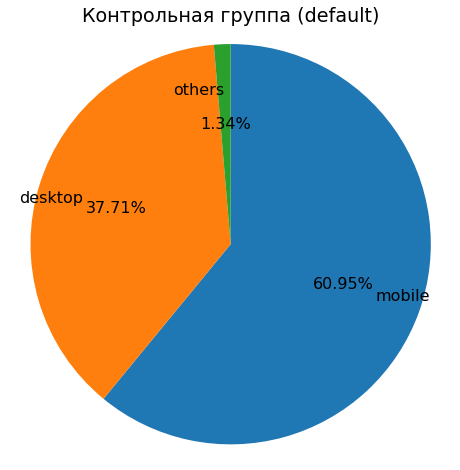

In [114]:
plt.figure(figsize=(8, 8))
plt.rcParams['font.size'] = 16.0
plt.pie(dev_type.hit_at, 
        labels=['mobile', 'desktop', 'others'], 
        autopct='%0.2f%%', labeldistance=0.77,
        counterclock=False, startangle=90);
plt.title('Контрольная группа (default)')
plt.axis('equal');
plt.savefig('control_device_pie.jpg')

In [115]:
dev_type = test.groupby('device_type').count().reset_index()[['device_type', 'hit_at']]

dev_type

,device_type,hit_at
0,console,1
1,desktop,20255
2,mobile,33287
3,smarttv,1
4,tablet,748


In [116]:
dev_type.loc[5] = ['others', 
                    dev_type.hit_at[0] + dev_type.hit_at[3] + dev_type.hit_at[4]]

dev_type = dev_type.sort_values('hit_at', ascending=False).reset_index(drop=True).head(3)

dev_type

,device_type,hit_at
0,mobile,33287
1,desktop,20255
2,others,750


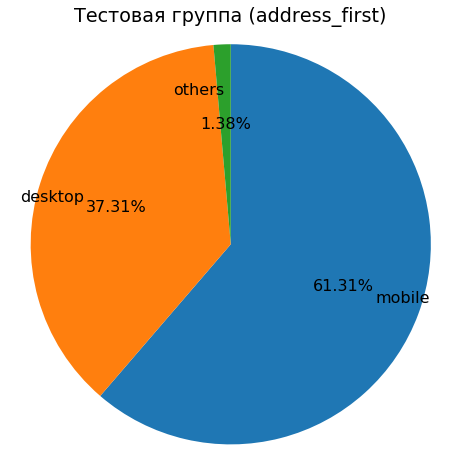

In [117]:
plt.figure(figsize=(8, 8))
plt.rcParams['font.size'] = 16.0
plt.pie(dev_type.hit_at, 
        labels=['mobile', 'desktop', 'others'], 
        autopct='%0.2f%%', labeldistance=0.77,
        counterclock=False, startangle=90);
plt.title('Тестовая группа (address_first)')
plt.axis('equal');

plt.savefig('test_device_pie.jpg')

##### Проверка по распределению типов OS внутри групп

In [118]:
os_type = default.groupby('os', as_index=False).count()[['os', 'hit_at']] \
    .sort_values('hit_at', ascending=False).reset_index(drop=True)

os_type#.hit_at.sum()

,os,hit_at
0,Android,169736
1,Windows,118501
2,iOS,101917
3,Linux,31325
4,Mac OS,12151
5,Ubuntu,441
6,Chromium OS,43
7,Windows Phone,32
8,Fedora,19
9,PlayStation,13


In [119]:
os_type.loc[3] = ['Linux', 
                    os_type.hit_at[3] + os_type.hit_at[5] + os_type.hit_at[6] + os_type.hit_at[8] + os_type.hit_at[10] + os_type.hit_at[13]]

os_type.loc[14] = ['others', 
                    os_type.hit_at[4] + os_type.hit_at[7] + os_type.hit_at[9] + os_type.hit_at[11] + os_type.hit_at[12]]


os_type = os_type.sort_values('hit_at', ascending=False).reset_index(drop=True) \
    .iloc[[0, 1, 2, 3, 4]]

os_type

,os,hit_at
0,Android,169736
1,Windows,118501
2,iOS,101917
3,Linux,31841
4,others,12203


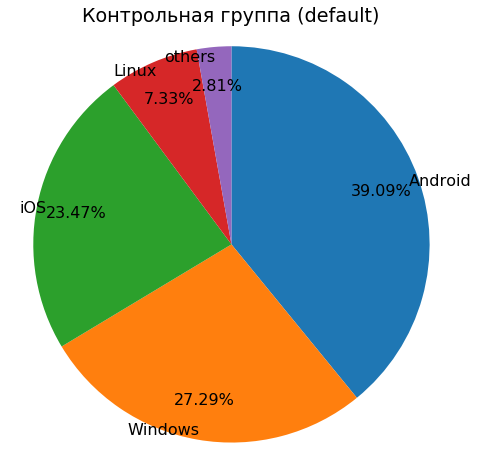

In [120]:
plt.figure(figsize=(8, 8))
plt.rcParams['font.size'] = 16.0
plt.pie(os_type.hit_at, 
        labels=['Android', 'Windows', 'iOS', 'Linux', 'others'], 
        autopct='%0.2f%%', 
        labeldistance=0.95, pctdistance=0.8, rotatelabels=False,
        counterclock=False, startangle=90);
plt.title('Контрольная группа (default)')
plt.axis('equal');
plt.savefig('control_os_pie.jpg')

In [121]:
os_type = test.groupby('os', as_index=False).count()[['os', 'hit_at']] \
    .sort_values('hit_at', ascending=False).reset_index(drop=True)

os_type#.hit_at.sum()

,os,hit_at
0,Android,21374
1,Windows,14652
2,iOS,12805
3,Linux,3877
4,Mac OS,1508
5,Ubuntu,60
6,Fedora,6
7,Chromium OS,5
8,Windows Phone,2
9,PlayStation,1


In [122]:
os_type.loc[3] = ['Linux', 
                    os_type.hit_at[3] + os_type.hit_at[5] + os_type.hit_at[6] + os_type.hit_at[7] + os_type.hit_at[10]]

os_type.loc[14] = ['others', 
                    os_type.hit_at[4] + os_type.hit_at[8] + os_type.hit_at[9] + os_type.hit_at[11]]


os_type = os_type.sort_values('hit_at', ascending=False).reset_index(drop=True) \
    .head()

os_type

,os,hit_at
0,Android,21374
1,Windows,14652
2,iOS,12805
3,Linux,3949
4,others,1512


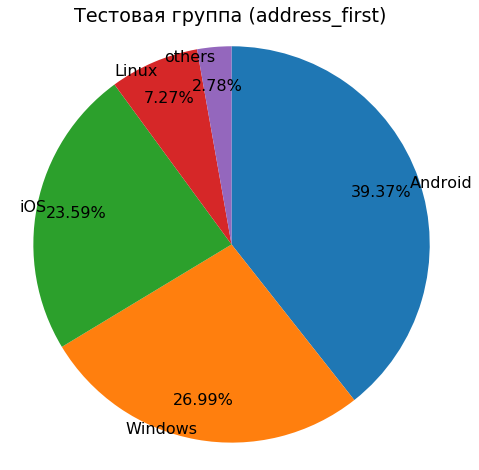

In [123]:
plt.figure(figsize=(8, 8))
plt.rcParams['font.size'] = 16.0
plt.pie(os_type.hit_at, 
        labels=['Android', 'Windows', 'iOS', 'Linux', 'others'], 
        autopct='%0.2f%%', 
        labeldistance=0.95, pctdistance=0.8, rotatelabels=False,
        counterclock=False, startangle=90);
plt.title('Тестовая группа (address_first)')
plt.axis('equal');
plt.savefig('test_os_pie.jpg')

##### Проверка по распределению типов браузеров внутри групп

In [124]:
browser_type = default.groupby('browser', as_index=False).count()[['browser', 'hit_at']] \
    .sort_values('hit_at', ascending=False).reset_index(drop=True)

browser_type#.hit_at.sum()

,browser,hit_at
0,Chrome,216615
1,Mobile Safari,71951
2,Yandex,46167
3,Chrome WebView,16599
4,WebKit,15821
5,Samsung Browser,13601
6,Firefox,12887
7,Opera,11098
8,MIUI Browser,10934
9,Safari,7528


In [125]:
browser_type.loc[37] = ['others', browser_type.iloc[5:].hit_at.sum()]


browser_type = browser_type.sort_values('hit_at', ascending=False).reset_index(drop=True).head()

In [126]:
browser_type = browser_type.iloc[[0, 1, 3, 4, 2]].reset_index(drop=True)

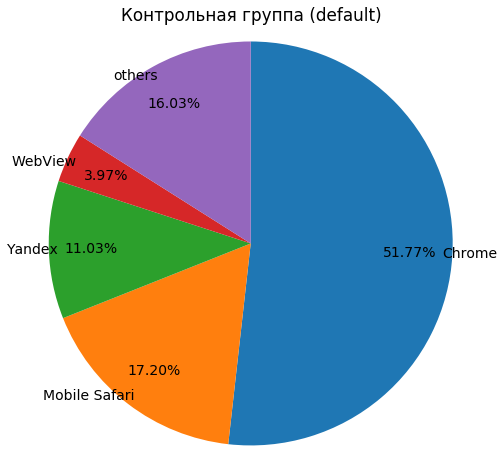

In [127]:
plt.figure(figsize=(8, 8))
plt.rcParams['font.size'] = 14.0
plt.pie(browser_type.hit_at, 
        labels=['Chrome', 'Mobile Safari', 'Yandex', 'WebView', 'others'], 
        autopct='%0.2f%%', 
        labeldistance=0.95, pctdistance=0.79, rotatelabels=False,
        counterclock=False, startangle=90);
plt.title('Контрольная группа (default)')
plt.axis('equal');
plt.savefig('control_browser_pie.jpg')

In [128]:
browser_type = test.groupby('browser', as_index=False).count()[['browser', 'hit_at']] \
    .sort_values('hit_at', ascending=False).reset_index(drop=True)

browser_type#.hit_at.sum()

,browser,hit_at
0,Chrome,27089
1,Mobile Safari,8935
2,Yandex,5806
3,Chrome WebView,2122
4,WebKit,2035
5,Samsung Browser,1661
6,Firefox,1600
7,Opera,1380
8,MIUI Browser,1362
9,Safari,939


In [129]:
browser_type.loc[26] = ['others', browser_type.iloc[5:].hit_at.sum()]


browser_type = browser_type.sort_values('hit_at', ascending=False).reset_index(drop=True).head()

In [130]:
browser_type = browser_type.iloc[[0, 1, 3, 4, 2]].reset_index(drop=True)

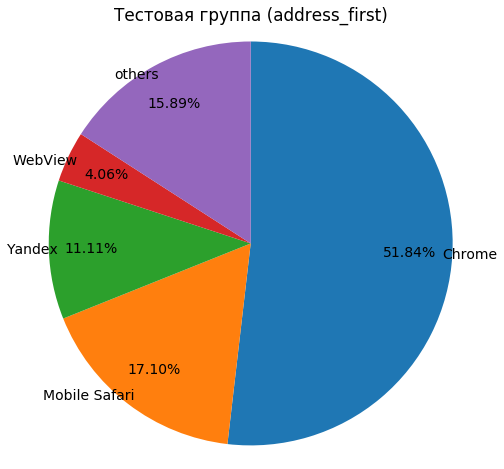

In [131]:
plt.figure(figsize=(8, 8))
plt.rcParams['font.size'] = 14.0
plt.pie(browser_type.hit_at, 
        labels=['Chrome', 'Mobile Safari', 'Yandex', 'WebView', 'others'], 
        autopct='%0.2f%%', 
        labeldistance=0.95, pctdistance=0.79, rotatelabels=False,
        counterclock=False, startangle=90);
plt.title('Тестовая группа (address_first)')
plt.axis('equal');
plt.savefig('test_browser_pie.jpg')

#### Bounce rate

##### default

In [132]:
default

,hit_at,anonymous_id,group,device_type,browser,os
467677,2020-11-26 00:00:10.318000+00:00,8fe5810d-905c-462d-944b-66921878fa7d,default,mobile,Chrome WebView,Android
432135,2020-11-26 00:00:17.474000+00:00,3ce00502-94c0-41c8-8165-20ea6d2ecd73,default,mobile,Mobile Safari,iOS
250308,2020-11-26 00:00:19.951000+00:00,e9030181-192e-4636-9691-2ba4d1eeabb2,default,desktop,Chrome,Windows
489342,2020-11-26 00:00:24.159000+00:00,20e24ee6-e40e-4f9a-9631-7db36332c734,default,mobile,Samsung Browser,Android
144584,2020-11-26 00:00:25.857000+00:00,e9480708-34a6-4356-8e65-b39664875cb9,default,mobile,Chrome,Android
...,...,...,...,...,...,...
30732,2020-12-10 23:59:18.618000+00:00,5e518207-82fb-48b9-9764-c167e84dc57c,default,desktop,Chrome,Linux
430450,2020-12-10 23:59:35.345000+00:00,90b60ec1-4d0e-4fab-8cf0-6c5c128ea5ec,default,mobile,Mobile Safari,iOS
35510,2020-12-10 23:59:36.293000+00:00,454c7515-0a58-4822-a431-d271e91da190,default,desktop,Chrome,Linux
199014,2020-12-10 23:59:48.461000+00:00,ad4b596b-88d3-41e9-969a-7d988039405b,default,desktop,Chrome,Windows


In [133]:
# landing viewed
default_lw = default.merge(landing_v, on='anonymous_id', how='inner') \
    .rename(columns={'timestamp' : 'landing_viewed'})

default_lw

,hit_at,anonymous_id,group,device_type,browser,os,landing_viewed
0,2020-11-26 00:00:24.159000+00:00,20e24ee6-e40e-4f9a-9631-7db36332c734,default,mobile,Samsung Browser,Android,2020-11-26 00:00:23.992000+00:00
1,2020-11-26 00:00:25.857000+00:00,e9480708-34a6-4356-8e65-b39664875cb9,default,mobile,Chrome,Android,2020-11-26 00:00:25.888000+00:00
2,2020-11-26 00:00:32.364000+00:00,d3a90bb4-b9d3-471a-b5d0-15837e369714,default,desktop,Chrome,Linux,2020-11-26 00:00:32.349000+00:00
3,2020-11-26 00:00:33.040000+00:00,4a2f6381-4a23-493c-bb97-626a65268397,default,desktop,Chrome,Linux,2020-11-26 00:00:33.026000+00:00
4,2020-11-26 00:01:33.215000+00:00,5ddc6caf-59f0-451c-b5ed-8c52548a67f9,default,desktop,Chrome,Mac OS,2020-11-26 00:01:33.352000+00:00
...,...,...,...,...,...,...,...
305129,2020-12-10 23:58:55.288000+00:00,251fb875-745b-4acd-8943-527cc0c518ef,default,mobile,Chrome,Android,2020-12-10 23:58:55.289000+00:00
305130,2020-12-10 23:59:11.239000+00:00,d68cd77b-f919-4841-a10f-f819b5526f79,default,mobile,Chrome,Android,2020-12-10 23:59:11.089000+00:00
305131,2020-12-10 23:59:18.618000+00:00,5e518207-82fb-48b9-9764-c167e84dc57c,default,desktop,Chrome,Linux,2020-12-10 23:59:18.603000+00:00
305132,2020-12-10 23:59:36.293000+00:00,454c7515-0a58-4822-a431-d271e91da190,default,desktop,Chrome,Linux,2020-12-10 23:59:36.278000+00:00


In [135]:
# помещаем просмотры лендинга в список
default_lw = default_lw[['anonymous_id', 'hit_at', 'landing_viewed']].groupby(['anonymous_id', 'hit_at'], as_index=False) \
    .agg(lambda x: list(x))

In [156]:
# добавим колонку с подсчетом просмотров лендинга пользователем
default_lw['landing_view_cnt'] = default_lw.landing_viewed.apply(lambda x: len(x))

default_lw = default_lw.sort_values('landing_view_cnt', ascending=False).reset_index(drop=True)

In [157]:
default_lw

,anonymous_id,hit_at,landing_viewed,landing_view_cnt
0,06eaec3d-511a-4794-92ea-a19efaaf7f19,2020-11-26 07:28:22.464000+00:00,"[2020-12-11 14:16:22.660000+00:00, 2020-12-11 ...",278
1,8851d1da-4b18-4028-baa6-47e8a135fe87,2020-12-02 08:59:21.322000+00:00,"[2020-12-02 13:43:16.363000+00:00, 2020-12-03 ...",170
2,3e3c5ef8-fb2d-4c9b-8de2-224c78ce4149,2020-11-28 17:08:13.424000+00:00,"[2020-11-30 20:55:57.702000+00:00, 2020-11-28 ...",142
3,bcaa113d-c128-443f-9ede-2736847e1969,2020-11-26 18:19:11.268000+00:00,"[2020-11-30 09:54:04.223000+00:00, 2020-12-05 ...",123
4,374fdafc-eaed-4265-bee1-ea62cd62d3bd,2020-11-27 15:59:33.515000+00:00,"[2020-12-03 05:57:38.380000+00:00, 2020-12-03 ...",91
...,...,...,...,...
187180,ec8570e4-84c6-4aaf-a415-d2abb8ca53c9,2020-11-26 17:41:11.463000+00:00,[2020-11-26 17:41:11.467000+00:00],1
187181,b44cb61a-d492-402d-863d-f1b16cec52d8,2020-11-29 17:29:14.257000+00:00,[2020-11-29 17:29:14.257000+00:00],1
187182,ec8533b5-e643-4e86-ba49-ccd8b6abae65,2020-11-27 17:31:16.988000+00:00,[2020-11-27 17:31:16.988000+00:00],1
187183,b44d94ca-42a3-4c37-b421-d7c90e589608,2020-11-30 16:12:13.741000+00:00,[2020-11-30 16:12:13.756000+00:00],1


In [165]:
# посомотрим диапазон дат для макисимального количетсва посещений лендинга (278 раз) одним пользователем
first_date = sorted(default_lw.iloc[0].landing_viewed)[0]
last_date = sorted(default_lw.iloc[0].landing_viewed)[-1]

print(first_date, last_date, sep='\n')

2020-11-26 07:28:22.465000+00:00
2020-12-17 21:50:05.049000+00:00


In [235]:
# подсчет межквартильного интервала
def iq_range(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    return q1, q3, q3 - q1

In [167]:
# подсчет межквартильного интервала default_lw
q1, q3, iqr = iq_range(default_lw, 'landing_view_cnt')

In [189]:
# убираем выбросы по количеству просмотров лендинга
default_lw_filt = default_lw.query('(@q1 - 1.5*@iqr) <= landing_view_cnt <= (@q3 + 1.5*@iqr)')
default_lw_filt

,anonymous_id,hit_at,landing_viewed,landing_view_cnt
12527,736b537a-d229-47f9-98d7-46f08c71a88e,2020-11-29 11:48:50.401000+00:00,"[2020-11-29 11:54:23.844000+00:00, 2020-11-29 ...",3
12528,320e2f3e-8339-4213-b368-db60a5e884bf,2020-12-02 18:52:38.270000+00:00,"[2020-12-11 19:32:47.092000+00:00, 2020-12-11 ...",3
12529,7413c611-9abc-4faa-8b3e-5a307584a0f1,2020-12-06 13:13:50.499000+00:00,"[2020-12-09 12:28:07.893000+00:00, 2020-12-06 ...",3
12530,98ecea4f-0ff8-49ac-82d4-4e806073bdac,2020-11-29 16:33:03.142000+00:00,"[2020-11-29 16:38:40.981000+00:00, 2020-11-29 ...",3
12531,f0c44e6d-69e3-452b-b5ba-d7af6f15d3a4,2020-12-04 05:33:37.679000+00:00,"[2020-12-04 05:33:37.649000+00:00, 2020-12-04 ...",3
...,...,...,...,...
187180,ec8570e4-84c6-4aaf-a415-d2abb8ca53c9,2020-11-26 17:41:11.463000+00:00,[2020-11-26 17:41:11.467000+00:00],1
187181,b44cb61a-d492-402d-863d-f1b16cec52d8,2020-11-29 17:29:14.257000+00:00,[2020-11-29 17:29:14.257000+00:00],1
187182,ec8533b5-e643-4e86-ba49-ccd8b6abae65,2020-11-27 17:31:16.988000+00:00,[2020-11-27 17:31:16.988000+00:00],1
187183,b44d94ca-42a3-4c37-b421-d7c90e589608,2020-11-30 16:12:13.741000+00:00,[2020-11-30 16:12:13.756000+00:00],1


In [179]:
# описательная статистика посещений лендинга до удаления выбросов
default_lw.landing_view_cnt.describe()

count    187185.000000
mean          1.630120
std           1.963639
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         278.000000
Name: landing_view_cnt, dtype: float64

In [192]:
# описательная статистика посещений лендинга после удаления выбросов
default_lw_filt.landing_view_cnt.describe()

count    174658.000000
mean          1.296299
std           0.576965
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           3.000000
Name: landing_view_cnt, dtype: float64

In [193]:
main_page_v

,timestamp,anonymous_id,retailer_id
0,2020-11-29 08:54:57.640000+00:00,00000782-154a-4159-ab12-6c34b658e375,1
1,2020-11-29 08:22:54.554000+00:00,00000782-154a-4159-ab12-6c34b658e375,1
2,2020-11-30 10:56:52.877000+00:00,00000782-154a-4159-ab12-6c34b658e375,1
3,2020-11-29 08:22:24.663000+00:00,00000782-154a-4159-ab12-6c34b658e375,1
4,2020-11-29 09:07:11.648000+00:00,00000782-154a-4159-ab12-6c34b658e375,1
...,...,...,...
613504,2020-11-26 09:53:21.894000+00:00,f62072ba-c666-4592-b2d5-627eafd445cd,253
613505,2020-12-01 15:47:22.935000+00:00,f7195120-87dc-404d-a31c-afcfad71cc35,253
613506,2020-11-28 17:03:38.479000+00:00,f84d997a-ce87-4e88-bf67-c2b1c50b71eb,253
613507,2020-11-29 13:38:47.575000+00:00,fa1f6122-363e-4264-a92d-701a6fe44161,253


In [206]:
# помещаем просмотры заглавной стрницы в список
mp_grouped = main_page_v.groupby(['anonymous_id'], as_index=False) \
    .agg(lambda x: list(x)) \
    .rename(columns={'timestamp': 'main_page_viewed'})

In [207]:
# добавим колонку с подсчетом просмотров заглавной страницы
mp_grouped['main_page_view_cnt'] = mp_grouped.main_page_viewed.apply(lambda x: len(x))

mp_grouped = mp_grouped.sort_values('main_page_view_cnt', ascending=False).reset_index(drop=True)

mp_grouped

,anonymous_id,main_page_viewed,retailer_id,main_page_view_cnt
0,06eaec3d-511a-4794-92ea-a19efaaf7f19,"[2020-12-05 15:32:29.367000+00:00, 2020-11-27 ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",478
1,0d14ce81-19d5-451c-9c7f-1886ed3f71a6,"[2020-11-29 17:27:04.619000+00:00, 2020-11-29 ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",463
2,5d2114f3-01ec-4313-8629-3cb44b4a2f9d,"[2020-11-26 14:38:05.474000+00:00, 2020-12-05 ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",437
3,f8c6d1f8-230a-465b-b14b-db1c21ad49ae,"[2020-12-11 16:14:22.469000+00:00, 2020-12-09 ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",425
4,ddeb13ba-f506-4c5e-ae9c-a3b2786cb56f,"[2020-12-09 16:51:44.887000+00:00, 2020-11-26 ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",404
...,...,...,...,...
161200,74dc3e22-3221-444c-b7f1-d259cd6b7c76,[2020-11-30 10:11:08.855000+00:00],[1],1
161201,74dbd1ba-c68e-4333-b264-80c1ae4fc7d8,[2020-12-09 15:55:48.210000+00:00],[1],1
161202,74d9e6ef-cecf-44bd-9882-7f994b46df94,[2020-11-28 04:15:18.082000+00:00],[1],1
161203,74d9affd-d12f-4385-b8af-828a1683547c,[2020-11-26 18:09:52.698000+00:00],[1],1


In [209]:
# описательная статистика просмотров заглавной страницы до объединения с информацией о просмотрах лендинга
mp_grouped.main_page_view_cnt.describe()

count    161205.000000
mean          3.804522
std           8.352212
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         478.000000
Name: main_page_view_cnt, dtype: float64

In [228]:
# добавляем информацию о просмотрах заглавной страницы к датасету с просмотрами лендинга
default_mpv = default_lw_filt.merge(mp_grouped, on='anonymous_id', how='left') \
    .sort_values('main_page_view_cnt', ascending=False) \
    .reset_index(drop=True)

default_mpv

,anonymous_id,hit_at,landing_viewed,landing_view_cnt,main_page_viewed,retailer_id,main_page_view_cnt
0,f8c6d1f8-230a-465b-b14b-db1c21ad49ae,2020-11-27 10:04:33.554000+00:00,[2020-11-27 10:04:33.554000+00:00],1,"[2020-12-11 16:14:22.469000+00:00, 2020-12-09 ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",425.0
1,ddeb13ba-f506-4c5e-ae9c-a3b2786cb56f,2020-12-10 13:12:38.736000+00:00,"[2020-12-02 15:30:46.957000+00:00, 2020-12-01 ...",3,"[2020-12-09 16:51:44.887000+00:00, 2020-11-26 ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",404.0
2,637e0f11-e9b7-42e4-ac2b-94b220bd6643,2020-11-28 06:58:26.728000+00:00,"[2020-11-28 06:59:40.398000+00:00, 2020-11-28 ...",2,"[2020-12-05 05:02:01.503000+00:00, 2020-12-12 ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",201.0
3,6d9393dd-d247-4f0d-9b89-cff18523cd7b,2020-12-07 20:08:16.304000+00:00,"[2020-12-07 20:08:23.027000+00:00, 2020-12-07 ...",2,"[2020-12-02 19:47:01.069000+00:00, 2020-12-08 ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",189.0
4,f1d57251-1373-458c-8b64-a8113414ff65,2020-12-02 15:56:15.765000+00:00,"[2020-12-02 15:56:15.765000+00:00, 2020-12-07 ...",3,"[2020-12-16 10:45:36.606000+00:00, 2020-11-26 ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",188.0
...,...,...,...,...,...,...,...
174653,ec85be1b-6698-407b-a143-70c9dbb6f942,2020-12-06 01:48:50.390000+00:00,[2020-12-06 01:48:50.390000+00:00],1,NaN,NaN,NaN
174654,ec8570e4-84c6-4aaf-a415-d2abb8ca53c9,2020-11-26 17:41:11.463000+00:00,[2020-11-26 17:41:11.467000+00:00],1,NaN,NaN,NaN
174655,b44cb61a-d492-402d-863d-f1b16cec52d8,2020-11-29 17:29:14.257000+00:00,[2020-11-29 17:29:14.257000+00:00],1,NaN,NaN,NaN
174656,ec8533b5-e643-4e86-ba49-ccd8b6abae65,2020-11-27 17:31:16.988000+00:00,[2020-11-27 17:31:16.988000+00:00],1,NaN,NaN,NaN


In [242]:
# описательная статистика просмотров заглавной страницы после объединения с информацией о просмотрах лендинга
default_mpv.main_page_view_cnt.describe()

count    174658.000000
mean          1.731819
std           5.113049
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         425.000000
Name: main_page_view_cnt, dtype: float64

In [229]:
# заполняем пропуски нулями для подсчета iqr
default_mpv['main_page_view_cnt'].fillna(0, inplace=True)
default_mpv['main_page_view_cnt'] = default_mpv['main_page_view_cnt'].astype({'main_page_view_cnt': 'int'})

In [236]:
# подсчет межквартильного интервала default_mpv
q1, q3, iqr = iq_range(default_mpv, 'main_page_view_cnt')

In [237]:
# убираем выбросы по количеству просмотров заглавной страницы
default_mpv_filt = default_mpv.query('(@q1 - 1.5*@iqr) <= main_page_view_cnt <= (@q3 + 1.5*@iqr)')
default_mpv_filt

,anonymous_id,hit_at,landing_viewed,landing_view_cnt,main_page_viewed,retailer_id,main_page_view_cnt
12838,6fd83b75-7317-47df-b75d-c9367a89e81b,2020-12-06 13:08:15.168000+00:00,"[2020-12-06 13:11:32.490000+00:00, 2020-12-06 ...",2,"[2020-12-06 13:09:30.422000+00:00, 2020-12-06 ...","[29, 29, 29, 29, 29]",5
12839,8558969b-fc04-4b5a-aaf1-94e3931778e5,2020-12-03 07:09:52.195000+00:00,[2020-12-03 07:09:52.415000+00:00],1,"[2020-12-02 10:41:52.574000+00:00, 2020-12-02 ...","[29, 29, 29, 29, 93]",5
12840,11787852-4b90-4b4b-9137-4d73b8570ff3,2020-12-02 04:05:42.992000+00:00,[2020-12-02 04:05:43.158000+00:00],1,"[2020-12-02 04:49:26.626000+00:00, 2020-12-02 ...","[1, 29, 29, 29, 29]",5
12841,3c605d1d-cd50-4a3e-a9af-e870027dd364,2020-11-29 12:51:06.300000+00:00,[2020-11-29 12:57:08.906000+00:00],1,"[2020-11-29 13:01:51.228000+00:00, 2020-11-29 ...","[29, 57, 57, 57, 57]",5
12842,b1587fb9-7094-41cd-93f4-6efa0c187737,2020-12-10 01:11:33.550000+00:00,[2020-12-10 01:11:33.686000+00:00],1,"[2020-12-10 20:19:21.244000+00:00, 2020-12-10 ...","[1, 1, 1, 29, 57]",5
...,...,...,...,...,...,...,...
174653,ec85be1b-6698-407b-a143-70c9dbb6f942,2020-12-06 01:48:50.390000+00:00,[2020-12-06 01:48:50.390000+00:00],1,NaN,NaN,0
174654,ec8570e4-84c6-4aaf-a415-d2abb8ca53c9,2020-11-26 17:41:11.463000+00:00,[2020-11-26 17:41:11.467000+00:00],1,NaN,NaN,0
174655,b44cb61a-d492-402d-863d-f1b16cec52d8,2020-11-29 17:29:14.257000+00:00,[2020-11-29 17:29:14.257000+00:00],1,NaN,NaN,0
174656,ec8533b5-e643-4e86-ba49-ccd8b6abae65,2020-11-27 17:31:16.988000+00:00,[2020-11-27 17:31:16.988000+00:00],1,NaN,NaN,0


In [244]:
# описательная статистика просмотров заглавной страницы после удаления выбросов
default_mpv_filt.main_page_view_cnt.describe()

count    161820.000000
mean          0.807589
std           1.244334
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           5.000000
Name: main_page_view_cnt, dtype: float64

##### bounce rate для default

In [251]:
# присвоим флаг для bounce (0 - было посещение после лендинга, 1 - single page session)
default_mpv_filt['bounce'] = default_mpv_filt['main_page_view_cnt'].apply(lambda x: 0 if x > 0 else 1)

default_mpv_filt

/home/nktnlx/yes/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,anonymous_id,hit_at,landing_viewed,landing_view_cnt,main_page_viewed,retailer_id,main_page_view_cnt,bounce
12838,6fd83b75-7317-47df-b75d-c9367a89e81b,2020-12-06 13:08:15.168000+00:00,"[2020-12-06 13:11:32.490000+00:00, 2020-12-06 ...",2,"[2020-12-06 13:09:30.422000+00:00, 2020-12-06 ...","[29, 29, 29, 29, 29]",5,0
12839,8558969b-fc04-4b5a-aaf1-94e3931778e5,2020-12-03 07:09:52.195000+00:00,[2020-12-03 07:09:52.415000+00:00],1,"[2020-12-02 10:41:52.574000+00:00, 2020-12-02 ...","[29, 29, 29, 29, 93]",5,0
12840,11787852-4b90-4b4b-9137-4d73b8570ff3,2020-12-02 04:05:42.992000+00:00,[2020-12-02 04:05:43.158000+00:00],1,"[2020-12-02 04:49:26.626000+00:00, 2020-12-02 ...","[1, 29, 29, 29, 29]",5,0
12841,3c605d1d-cd50-4a3e-a9af-e870027dd364,2020-11-29 12:51:06.300000+00:00,[2020-11-29 12:57:08.906000+00:00],1,"[2020-11-29 13:01:51.228000+00:00, 2020-11-29 ...","[29, 57, 57, 57, 57]",5,0
12842,b1587fb9-7094-41cd-93f4-6efa0c187737,2020-12-10 01:11:33.550000+00:00,[2020-12-10 01:11:33.686000+00:00],1,"[2020-12-10 20:19:21.244000+00:00, 2020-12-10 ...","[1, 1, 1, 29, 57]",5,0
...,...,...,...,...,...,...,...,...
174653,ec85be1b-6698-407b-a143-70c9dbb6f942,2020-12-06 01:48:50.390000+00:00,[2020-12-06 01:48:50.390000+00:00],1,NaN,NaN,0,1
174654,ec8570e4-84c6-4aaf-a415-d2abb8ca53c9,2020-11-26 17:41:11.463000+00:00,[2020-11-26 17:41:11.467000+00:00],1,NaN,NaN,0,1
174655,b44cb61a-d492-402d-863d-f1b16cec52d8,2020-11-29 17:29:14.257000+00:00,[2020-11-29 17:29:14.257000+00:00],1,NaN,NaN,0,1
174656,ec8533b5-e643-4e86-ba49-ccd8b6abae65,2020-11-27 17:31:16.988000+00:00,[2020-11-27 17:31:16.988000+00:00],1,NaN,NaN,0,1


In [301]:
# посчитаем bounce rate для default группы
round(default_mpv_filt.bounce.value_counts(normalize=True)[1] * 100, 2)

59.74

##### test

In [263]:
# landing viewed
test_lw = test.merge(landing_v, on='anonymous_id', how='inner') \
    .rename(columns={'timestamp' : 'landing_viewed'})

test_lw

,hit_at,anonymous_id,group,device_type,browser,os,landing_viewed
0,2020-11-26 00:00:19.020000+00:00,64f2ed52-52be-4171-917f-1834c0f736f2,address_first,desktop,Chrome,Linux,2020-11-26 00:00:19.019000+00:00
1,2020-11-26 00:04:16.775000+00:00,48e03311-f213-4b63-b2f9-ff2508b54a03,address_first,desktop,Chrome,Linux,2020-11-26 00:04:16.776000+00:00
2,2020-11-26 00:04:58.764000+00:00,85932680-44e5-4fd2-88dd-03167615f424,address_first,desktop,Chrome,Linux,2020-11-26 00:04:58.765000+00:00
3,2020-11-26 00:05:18.216000+00:00,a4ea1971-f41e-4943-921e-5142c7173ef1,address_first,desktop,Chrome,Linux,2020-11-26 00:05:18.216000+00:00
4,2020-11-26 00:08:29.442000+00:00,3543a788-6bc4-448e-9e97-ac5da585d7a4,address_first,desktop,Chrome,Linux,2020-11-26 00:08:29.457000+00:00
...,...,...,...,...,...,...,...
35555,2020-12-10 23:47:10.128000+00:00,fc9a8035-4ad1-40d2-95ec-48dd0a90683d,address_first,desktop,Chrome,Linux,2020-12-10 23:47:10.128000+00:00
35556,2020-12-10 23:47:18.410000+00:00,c76dbf12-1f78-485e-8384-c7c2241b07ea,address_first,desktop,Chrome,Linux,2020-12-10 23:47:18.409000+00:00
35557,2020-12-10 23:48:22.844000+00:00,6f351e94-2668-4927-86be-1c307e52329c,address_first,desktop,Chrome,Linux,2020-12-10 23:48:22.850000+00:00
35558,2020-12-10 23:51:19.562000+00:00,7f0a4f10-c49c-45a2-bb9e-92b4877b06eb,address_first,mobile,Chrome,Android,2020-12-10 23:51:19.562000+00:00


In [264]:
# помещаем просмотры лендинга в список
test_lw = test_lw[['anonymous_id', 'hit_at', 'landing_viewed']].groupby(['anonymous_id', 'hit_at'], as_index=False) \
    .agg(lambda x: list(x))

In [265]:
# добавим колонку с подсчетом просмотров лендинга пользователем
test_lw['landing_view_cnt'] = test_lw.landing_viewed.apply(lambda x: len(x))

test_lw = test_lw.sort_values('landing_view_cnt', ascending=False).reset_index(drop=True)

In [266]:
test_lw

,anonymous_id,hit_at,landing_viewed,landing_view_cnt
0,6368eb82-d361-4aca-869e-080f167e3b5f,2020-12-01 00:57:15.357000+00:00,"[2020-12-01 00:57:47.439000+00:00, 2020-12-01 ...",532
1,8da49d4a-48a7-4e27-8a16-5d122c9602c4,2020-12-02 17:14:50.225000+00:00,"[2020-12-08 15:26:04.107000+00:00, 2020-12-08 ...",126
2,43565189-ddcb-4d0e-981c-91eb105ee2aa,2020-12-03 07:43:42.571000+00:00,"[2020-12-10 17:37:24.233000+00:00, 2020-12-11 ...",83
3,f20faf0a-75c6-41d4-a12e-472ce3b923b8,2020-11-27 18:11:49.984000+00:00,"[2020-12-12 19:01:52.862000+00:00, 2020-12-13 ...",47
4,cedad510-b65c-4077-82b2-88b020e62f79,2020-11-26 20:37:53.819000+00:00,"[2020-11-27 06:46:01.309000+00:00, 2020-11-27 ...",38
...,...,...,...,...
23545,6117f53f-ed37-443d-be6d-b5bd1d61088d,2020-11-27 18:24:07.506000+00:00,[2020-11-27 18:24:07.655000+00:00],1
23546,6115517c-bb51-4068-85fb-c64b75638dee,2020-12-03 13:06:01.228000+00:00,[2020-12-03 13:06:01.258000+00:00],1
23547,6114feb3-5192-47ab-a61b-4f45a33646f7,2020-12-03 08:05:17.151000+00:00,[2020-12-03 08:07:15.844000+00:00],1
23548,611386ec-1212-4e3c-8569-61d6ac055e8f,2020-11-26 13:46:18.473000+00:00,[2020-11-26 13:46:18.473000+00:00],1


In [267]:
# посомотрим диапазон дат для макисимального количетсва посещений лендинга (532 раз) одним пользователем
first_date = sorted(test_lw.iloc[0].landing_viewed)[0]
last_date = sorted(test_lw.iloc[0].landing_viewed)[-1]

print(first_date, last_date, sep='\n')

2020-12-01 00:57:13.875000+00:00
2020-12-01 01:27:25.050000+00:00


In [235]:
# подсчет межквартильного интервала
def iq_range(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    return q1, q3, q3 - q1

In [268]:
# подсчет межквартильного интервала default_lw
q1, q3, iqr = iq_range(test_lw, 'landing_view_cnt')

In [269]:
# убираем выбросы по количеству просмотров лендинга
test_lw_filt = test_lw.query('(@q1 - 1.5*@iqr) <= landing_view_cnt <= (@q3 + 1.5*@iqr)')
test_lw_filt

,anonymous_id,hit_at,landing_viewed,landing_view_cnt
5584,b1a937b9-6cdf-471a-bbc8-5f174cd6bc38,2020-12-04 19:09:27.293000+00:00,[2020-12-04 19:09:27.233000+00:00],1
5585,b19fb964-747b-4741-a07c-03db74987ba7,2020-11-26 15:55:36.346000+00:00,[2020-11-26 15:55:36.376000+00:00],1
5586,906fba24-63d8-47c7-b634-2d04ec0f3d02,2020-11-26 02:29:16.233000+00:00,[2020-11-26 02:29:16.233000+00:00],1
5587,b19f3e94-0af9-40b5-bd29-d24b6113588d,2020-12-02 08:48:33.873000+00:00,[2020-12-02 08:48:33.873000+00:00],1
5588,9645e242-b7bf-47c3-9015-01b51dcb0daa,2020-12-09 02:53:23.620000+00:00,[2020-12-09 02:53:23.575000+00:00],1
...,...,...,...,...
23545,6117f53f-ed37-443d-be6d-b5bd1d61088d,2020-11-27 18:24:07.506000+00:00,[2020-11-27 18:24:07.655000+00:00],1
23546,6115517c-bb51-4068-85fb-c64b75638dee,2020-12-03 13:06:01.228000+00:00,[2020-12-03 13:06:01.258000+00:00],1
23547,6114feb3-5192-47ab-a61b-4f45a33646f7,2020-12-03 08:05:17.151000+00:00,[2020-12-03 08:07:15.844000+00:00],1
23548,611386ec-1212-4e3c-8569-61d6ac055e8f,2020-11-26 13:46:18.473000+00:00,[2020-11-26 13:46:18.473000+00:00],1


In [271]:
# описательная статистика посещений лендинга до удаления выбросов
test_lw.landing_view_cnt.describe()

count    23550.000000
mean         1.509979
std          3.872535
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        532.000000
Name: landing_view_cnt, dtype: float64

In [272]:
# описательная статистика посещений лендинга после удаления выбросов
test_lw_filt.landing_view_cnt.describe()

count    17966.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: landing_view_cnt, dtype: float64

In [280]:
# отбираем только переходы с лендинга
address_c_landing = address_c[address_c['source'] == 'landing']

address_c_landing

,timestamp,anonymous_id,source
31643,2020-11-28 09:19:15.269000+00:00,0007e6dd-f368-4108-bd3c-93fd3dc4f880,landing
31644,2020-11-28 11:03:05.779000+00:00,000aad95-885c-4d32-80c1-c53434a17ac9,landing
31645,2020-12-09 06:52:47.760000+00:00,0015e7d0-b4be-4fef-918c-668cc4bad1ea,landing
31646,2020-12-04 20:15:29.136000+00:00,00292def-6714-49fe-940a-5cfda3cbf84b,landing
31647,2020-12-04 06:33:53.533000+00:00,004aec46-3e7f-4003-bd37-a665d6acd719,landing
...,...,...,...
44721,2020-12-05 07:42:25.191000+00:00,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,landing
44722,2020-11-28 15:12:50.754000+00:00,ffede279-08d7-4d51-b5d5-d6e5e8983900,landing
44723,2020-12-02 18:37:58.820000+00:00,ffef2c0e-814d-477c-a0cd-352163f52528,landing
44724,2020-11-26 15:22:46.495000+00:00,fffa7926-b5a3-4533-a737-c6e4f351243b,landing


In [281]:
# помещаем просмотры заглавной стрницы в список
address_c_grouped = address_c_landing.groupby(['anonymous_id'], as_index=False) \
    .agg(lambda x: list(x)) \
    .rename(columns={'timestamp': 'main_page_viewed'})

In [282]:
# добавим колонку с подсчетом просмотров заглавной страницы
address_c_grouped['main_page_view_cnt'] = address_c_grouped.main_page_viewed.apply(lambda x: len(x))

address_c_grouped = address_c_grouped.sort_values('main_page_view_cnt', ascending=False).reset_index(drop=True)

address_c_grouped

,anonymous_id,main_page_viewed,source,main_page_view_cnt
0,0d82c7f8-f2f0-4b22-a7ae-d430febadb15,"[2020-12-02 11:48:50.334000+00:00, 2020-12-02 ...","[landing, landing, landing, landing, landing, ...",25
1,f5352ff3-0833-4b82-a8ea-afa154a9f440,"[2020-12-08 14:56:46.028000+00:00, 2020-12-08 ...","[landing, landing, landing, landing, landing, ...",21
2,bd2d24ed-057d-46f8-a723-3d76617fc745,"[2020-12-12 07:56:30.852000+00:00, 2020-12-12 ...","[landing, landing, landing, landing, landing, ...",21
3,30295241-3542-4924-9f7d-71de252e2f59,"[2020-12-09 12:38:06.688000+00:00, 2020-12-09 ...","[landing, landing, landing, landing, landing, ...",19
4,1b2fda8f-0ea2-4656-a116-fd585cce42d6,"[2020-12-08 13:12:42.723000+00:00, 2020-12-08 ...","[landing, landing, landing, landing, landing, ...",16
...,...,...,...,...
8758,61ef4b32-3a60-4017-bab2-16d733ba86ba,[2020-12-03 09:32:12.297000+00:00],[landing],1
8759,61edcf66-629c-49fa-8474-ae537b395899,[2020-12-05 18:15:40.526000+00:00],[landing],1
8760,61ea3df4-7225-4363-9f82-c42d0dffd359,[2020-11-26 13:27:40.852000+00:00],[landing],1
8761,61e6c270-0b0d-43b0-a75d-afa013608d16,[2020-12-10 22:12:38.506000+00:00],[landing],1


In [283]:
# описательная статистика просмотров заглавной страницы до объединения с информацией о просмотрах лендинга
address_c_grouped.main_page_view_cnt.describe()

count    8763.000000
mean        1.491727
std         1.166867
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        25.000000
Name: main_page_view_cnt, dtype: float64

In [284]:
# добавляем информацию о просмотрах заглавной страницы к датасету с просмотрами лендинга
test_mpv = test_lw_filt.merge(address_c_grouped, on='anonymous_id', how='left') \
    .sort_values('main_page_view_cnt', ascending=False) \
    .reset_index(drop=True)

test_mpv

,anonymous_id,hit_at,landing_viewed,landing_view_cnt,main_page_viewed,source,main_page_view_cnt
0,30295241-3542-4924-9f7d-71de252e2f59,2020-12-09 12:36:43.524000+00:00,[2020-12-09 12:36:43.525000+00:00],1,"[2020-12-09 12:38:06.688000+00:00, 2020-12-09 ...","[landing, landing, landing, landing, landing, ...",19.0
1,efdfdf43-0048-4a4c-9d72-5a99651e6cdd,2020-12-10 09:00:20.523000+00:00,[2020-12-10 09:00:20.524000+00:00],1,"[2020-12-10 09:01:35.023000+00:00, 2020-12-10 ...","[landing, landing, landing, landing, landing, ...",16.0
2,1b2fda8f-0ea2-4656-a116-fd585cce42d6,2020-12-08 13:11:36.504000+00:00,[2020-12-08 13:11:36.640000+00:00],1,"[2020-12-08 13:12:42.723000+00:00, 2020-12-08 ...","[landing, landing, landing, landing, landing, ...",16.0
3,7f848348-27d9-4056-9326-bde420e52fb7,2020-12-08 14:27:57.425000+00:00,[2020-12-08 14:27:57.409000+00:00],1,"[2020-12-08 15:18:12.522000+00:00, 2020-12-08 ...","[landing, landing, landing, landing, landing, ...",10.0
4,28c8e99e-333e-4039-9684-73803f45a04c,2020-12-08 08:55:27.641000+00:00,[2020-12-08 08:55:27.640000+00:00],1,"[2020-12-08 08:56:28.714000+00:00, 2020-12-08 ...","[landing, landing, landing, landing, landing, ...",9.0
...,...,...,...,...,...,...,...
17961,611e749e-9bbd-411c-9cdb-21d36d852495,2020-12-07 12:27:20.506000+00:00,[2020-12-07 12:27:20.673000+00:00],1,NaN,NaN,NaN
17962,6117f53f-ed37-443d-be6d-b5bd1d61088d,2020-11-27 18:24:07.506000+00:00,[2020-11-27 18:24:07.655000+00:00],1,NaN,NaN,NaN
17963,6115517c-bb51-4068-85fb-c64b75638dee,2020-12-03 13:06:01.228000+00:00,[2020-12-03 13:06:01.258000+00:00],1,NaN,NaN,NaN
17964,611386ec-1212-4e3c-8569-61d6ac055e8f,2020-11-26 13:46:18.473000+00:00,[2020-11-26 13:46:18.473000+00:00],1,NaN,NaN,NaN


In [285]:
# описательная статистика просмотров заглавной страницы после объединения с информацией о просмотрах лендинга
test_mpv.main_page_view_cnt.describe()

count    5985.000000
mean        1.200501
std         0.707272
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        19.000000
Name: main_page_view_cnt, dtype: float64

In [286]:
# заполняем пропуски нулями для подсчета iqr
test_mpv['main_page_view_cnt'].fillna(0, inplace=True)
test_mpv['main_page_view_cnt'] = test_mpv['main_page_view_cnt'].astype({'main_page_view_cnt': 'int'})

In [287]:
# подсчет межквартильного интервала default_mpv
q1, q3, iqr = iq_range(test_mpv, 'main_page_view_cnt')

In [288]:
# убираем выбросы по количеству просмотров заглавной страницы
test_mpv_filt = test_mpv.query('(@q1 - 1.5*@iqr) <= main_page_view_cnt <= (@q3 + 1.5*@iqr)')
test_mpv_filt

,anonymous_id,hit_at,landing_viewed,landing_view_cnt,main_page_viewed,source,main_page_view_cnt
192,ce3e9c63-04af-4628-80b8-bba26a72894f,2020-12-04 04:24:49.452000+00:00,[2020-12-04 04:24:49.452000+00:00],1,"[2020-12-04 04:25:31.602000+00:00, 2020-12-04 ...","[landing, landing]",2
193,e54f1338-662b-4a72-aefe-f8b648169506,2020-12-10 15:51:03.300000+00:00,[2020-12-10 15:51:03.293000+00:00],1,"[2020-12-10 15:52:06.738000+00:00, 2020-12-10 ...","[landing, landing]",2
194,4b681db3-d759-4828-8de5-fe0123d6b962,2020-12-05 07:09:43.002000+00:00,[2020-12-05 07:09:43.033000+00:00],1,"[2020-12-05 07:09:56.586000+00:00, 2020-12-05 ...","[landing, landing]",2
195,0705203f-d138-4847-9380-d6a582f56c30,2020-12-02 12:35:00.310000+00:00,[2020-12-02 12:35:00.310000+00:00],1,"[2020-12-02 12:35:21.534000+00:00, 2020-12-02 ...","[landing, landing]",2
196,e7f1c723-1e24-4602-9d70-9f83ce5ded5b,2020-12-02 19:27:31.065000+00:00,[2020-12-02 19:36:19.968000+00:00],1,"[2020-12-02 19:36:49.538000+00:00, 2020-12-02 ...","[landing, landing]",2
...,...,...,...,...,...,...,...
17961,611e749e-9bbd-411c-9cdb-21d36d852495,2020-12-07 12:27:20.506000+00:00,[2020-12-07 12:27:20.673000+00:00],1,NaN,NaN,0
17962,6117f53f-ed37-443d-be6d-b5bd1d61088d,2020-11-27 18:24:07.506000+00:00,[2020-11-27 18:24:07.655000+00:00],1,NaN,NaN,0
17963,6115517c-bb51-4068-85fb-c64b75638dee,2020-12-03 13:06:01.228000+00:00,[2020-12-03 13:06:01.258000+00:00],1,NaN,NaN,0
17964,611386ec-1212-4e3c-8569-61d6ac055e8f,2020-11-26 13:46:18.473000+00:00,[2020-11-26 13:46:18.473000+00:00],1,NaN,NaN,0


In [289]:
# описательная статистика просмотров заглавной страницы после удаления выбросов
test_mpv_filt.main_page_view_cnt.describe()

count    17774.000000
mean         0.360695
std          0.547860
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          2.000000
Name: main_page_view_cnt, dtype: float64

##### bounce rate для test

In [290]:
# присвоим флаг для bounce (0 - было посещение после лендинга, 1 - single page session)
test_mpv_filt['bounce'] = test_mpv_filt['main_page_view_cnt'].apply(lambda x: 0 if x > 0 else 1)

test_mpv_filt

/home/nktnlx/yes/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,anonymous_id,hit_at,landing_viewed,landing_view_cnt,main_page_viewed,source,main_page_view_cnt,bounce
192,ce3e9c63-04af-4628-80b8-bba26a72894f,2020-12-04 04:24:49.452000+00:00,[2020-12-04 04:24:49.452000+00:00],1,"[2020-12-04 04:25:31.602000+00:00, 2020-12-04 ...","[landing, landing]",2,0
193,e54f1338-662b-4a72-aefe-f8b648169506,2020-12-10 15:51:03.300000+00:00,[2020-12-10 15:51:03.293000+00:00],1,"[2020-12-10 15:52:06.738000+00:00, 2020-12-10 ...","[landing, landing]",2,0
194,4b681db3-d759-4828-8de5-fe0123d6b962,2020-12-05 07:09:43.002000+00:00,[2020-12-05 07:09:43.033000+00:00],1,"[2020-12-05 07:09:56.586000+00:00, 2020-12-05 ...","[landing, landing]",2,0
195,0705203f-d138-4847-9380-d6a582f56c30,2020-12-02 12:35:00.310000+00:00,[2020-12-02 12:35:00.310000+00:00],1,"[2020-12-02 12:35:21.534000+00:00, 2020-12-02 ...","[landing, landing]",2,0
196,e7f1c723-1e24-4602-9d70-9f83ce5ded5b,2020-12-02 19:27:31.065000+00:00,[2020-12-02 19:36:19.968000+00:00],1,"[2020-12-02 19:36:49.538000+00:00, 2020-12-02 ...","[landing, landing]",2,0
...,...,...,...,...,...,...,...,...
17961,611e749e-9bbd-411c-9cdb-21d36d852495,2020-12-07 12:27:20.506000+00:00,[2020-12-07 12:27:20.673000+00:00],1,NaN,NaN,0,1
17962,6117f53f-ed37-443d-be6d-b5bd1d61088d,2020-11-27 18:24:07.506000+00:00,[2020-11-27 18:24:07.655000+00:00],1,NaN,NaN,0,1
17963,6115517c-bb51-4068-85fb-c64b75638dee,2020-12-03 13:06:01.228000+00:00,[2020-12-03 13:06:01.258000+00:00],1,NaN,NaN,0,1
17964,611386ec-1212-4e3c-8569-61d6ac055e8f,2020-11-26 13:46:18.473000+00:00,[2020-11-26 13:46:18.473000+00:00],1,NaN,NaN,0,1


In [300]:
# посчитаем bounce rate для test группы
round(test_mpv_filt.bounce.value_counts(normalize=True)[1] * 100, 2)

67.41

##### Bounce rate AB-test

In [304]:
# выборка данных тестовой группы
test_bounce = test_mpv_filt.bounce

1    0.674074
0    0.325926
Name: bounce, dtype: float64

In [308]:
# выборка данных контрольной группы
default_bounce = default_mpv_filt.bounce

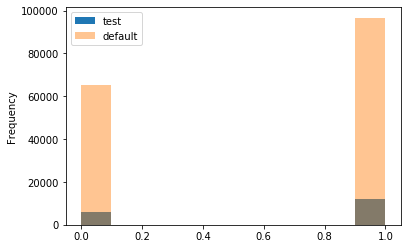

In [369]:
# построим распределение 
test_bounce.plot(kind='hist', alpha=1, legend=True, label='test')
default_bounce.plot(kind='hist', alpha=0.45, legend=True, label='default');

In [319]:
# проведем Z-test для двух выборок c биномиальным распределением
alpha = 0.05  # уровень статистической значимости

zscore, pvalue = proportions_ztest([sum(test_bounce), sum(default_bounce)], [len(test_bounce), len(default_bounce)],
                                   alternative = 'two-sided')
print('zscore = {:.4f}, pvalue = {:.4e}'.format(zscore, pvalue))

if pvalue <= alpha:
    print('Результат теста cтатзначимый.')
    if test_bounce.mean() > default_bounce.mean():
        print('Bounce rate лендинга вырос в тестовой группе.')
    else:
        print('Bounce rate лендинга в тестовой группе не увеличился.')
else:
    print('Не удалось отвергнуть нулевую гипотезу о равенстве результатов и получить статзначимый результат.')

zscore = 19.8415, pvalue = 1.3050e-87
Результат теста cтатзначимый.
Bounce rate лендинга вырос в тестовой группе.


#### конверсия в добавление в корзину

##### default

In [343]:
default

,hit_at,anonymous_id,group,device_type,browser,os
467677,2020-11-26 00:00:10.318000+00:00,8fe5810d-905c-462d-944b-66921878fa7d,default,mobile,Chrome WebView,Android
432135,2020-11-26 00:00:17.474000+00:00,3ce00502-94c0-41c8-8165-20ea6d2ecd73,default,mobile,Mobile Safari,iOS
250308,2020-11-26 00:00:19.951000+00:00,e9030181-192e-4636-9691-2ba4d1eeabb2,default,desktop,Chrome,Windows
489342,2020-11-26 00:00:24.159000+00:00,20e24ee6-e40e-4f9a-9631-7db36332c734,default,mobile,Samsung Browser,Android
144584,2020-11-26 00:00:25.857000+00:00,e9480708-34a6-4356-8e65-b39664875cb9,default,mobile,Chrome,Android
...,...,...,...,...,...,...
30732,2020-12-10 23:59:18.618000+00:00,5e518207-82fb-48b9-9764-c167e84dc57c,default,desktop,Chrome,Linux
430450,2020-12-10 23:59:35.345000+00:00,90b60ec1-4d0e-4fab-8cf0-6c5c128ea5ec,default,mobile,Mobile Safari,iOS
35510,2020-12-10 23:59:36.293000+00:00,454c7515-0a58-4822-a431-d271e91da190,default,desktop,Chrome,Linux
199014,2020-12-10 23:59:48.461000+00:00,ad4b596b-88d3-41e9-969a-7d988039405b,default,desktop,Chrome,Windows


In [328]:
# помещаем фактические добавления продукта в список
added_grouped = product_added.groupby('anonymous_id', as_index=False).agg(lambda x: list(x)) \
    .rename(columns={'timestamp': 'product_added'})

added_grouped

,anonymous_id,product_added
0,00000782-154a-4159-ab12-6c34b658e375,"[2020-11-29 08:36:59.486000+00:00, 2020-11-29 ..."
1,00021d91-c65e-4049-9ae1-7d64702c8c12,"[2020-12-01 08:27:56.618000+00:00, 2020-12-01 ..."
2,0003ca8f-bb3f-4954-84c7-1fbf2353a454,"[2020-11-27 15:36:24.140000+00:00, 2020-11-27 ..."
3,0004225d-57d6-44af-8f41-93958b41fbc4,"[2020-12-16 10:26:33.596000+00:00, 2020-12-16 ..."
4,00048409-3554-4049-907b-88401056d5b0,"[2020-12-04 10:39:17.660000+00:00, 2020-12-04 ..."
...,...,...
44118,fffbbed0-9af0-436d-b6de-4d530c9f7112,"[2020-12-06 14:09:21.552000+00:00, 2020-12-06 ..."
44119,fffdff7b-8f24-4c0d-a1e5-0342941fedf3,[2020-11-27 13:39:00.143000+00:00]
44120,fffec437-954e-423e-8b01-050c1f787377,"[2020-12-02 16:00:04.084000+00:00, 2020-12-02 ..."
44121,fffedf6a-7be6-4313-a0d9-ff87463ba6e8,"[2020-12-05 14:38:46.400000+00:00, 2020-12-13 ..."


In [329]:
# добавим колонку с подсчетом добавленных товаров
added_grouped['product_added_cnt'] = added_grouped.product_added.apply(lambda x: len(x))

added_grouped = added_grouped.sort_values('product_added_cnt', ascending=False).reset_index(drop=True)

added_grouped

,anonymous_id,product_added,product_added_cnt
0,3e5732f3-b0fb-4c1f-8bed-dd7a68994585,"[2020-12-16 17:39:36.073000+00:00, 2020-12-10 ...",1031
1,ae52ad7a-075a-4e5d-8cd3-d09d72822a8d,"[2020-11-28 07:34:46.043000+00:00, 2020-11-26 ...",953
2,2bec5d04-635a-4c36-a4ee-2e1dfa7f04d1,"[2020-11-27 13:35:14.855000+00:00, 2020-11-28 ...",779
3,cc5ae342-601e-40e0-ae49-d60aaada414f,"[2020-12-16 18:34:45.114000+00:00, 2020-12-14 ...",709
4,49bf3b2d-8c91-43f9-a5df-5b0643290dba,"[2020-12-14 19:23:14.190000+00:00, 2020-12-14 ...",670
...,...,...,...
44118,7adaccb9-2dc6-4205-ad74-f0dccc9f33a9,[2020-12-04 20:22:15.112000+00:00],1
44119,d055ebdd-fb77-464d-9362-f0c703e6caf7,[2020-12-14 05:08:53.073000+00:00],1
44120,3c41e414-b6d1-463a-bb83-2c7f74509968,[2020-12-06 12:06:39.258000+00:00],1
44121,d0503955-a20a-4449-8da0-fa8fac42ddf4,[2020-12-06 19:14:00.428000+00:00],1


In [330]:
# описательная статистика количества добваленных товаров пользователем
added_grouped.product_added_cnt.describe()

count    44123.000000
mean        26.064864
std         38.475931
min          1.000000
25%          3.000000
50%         14.000000
75%         33.000000
max       1031.000000
Name: product_added_cnt, dtype: float64

In [350]:
# product added merge
default_added = default.merge(added_grouped, on='anonymous_id', how='left')

default_added

,hit_at,anonymous_id,group,device_type,browser,os,product_added,product_added_cnt
0,2020-11-26 00:00:10.318000+00:00,8fe5810d-905c-462d-944b-66921878fa7d,default,mobile,Chrome WebView,Android,NaN,NaN
1,2020-11-26 00:00:17.474000+00:00,3ce00502-94c0-41c8-8165-20ea6d2ecd73,default,mobile,Mobile Safari,iOS,NaN,NaN
2,2020-11-26 00:00:19.951000+00:00,e9030181-192e-4636-9691-2ba4d1eeabb2,default,desktop,Chrome,Windows,NaN,NaN
3,2020-11-26 00:00:24.159000+00:00,20e24ee6-e40e-4f9a-9631-7db36332c734,default,mobile,Samsung Browser,Android,NaN,NaN
4,2020-11-26 00:00:25.857000+00:00,e9480708-34a6-4356-8e65-b39664875cb9,default,mobile,Chrome,Android,NaN,NaN
...,...,...,...,...,...,...,...,...
434194,2020-12-10 23:59:18.618000+00:00,5e518207-82fb-48b9-9764-c167e84dc57c,default,desktop,Chrome,Linux,NaN,NaN
434195,2020-12-10 23:59:35.345000+00:00,90b60ec1-4d0e-4fab-8cf0-6c5c128ea5ec,default,mobile,Mobile Safari,iOS,NaN,NaN
434196,2020-12-10 23:59:36.293000+00:00,454c7515-0a58-4822-a431-d271e91da190,default,desktop,Chrome,Linux,NaN,NaN
434197,2020-12-10 23:59:48.461000+00:00,ad4b596b-88d3-41e9-969a-7d988039405b,default,desktop,Chrome,Windows,NaN,NaN


In [351]:
# заполняем пропуски нулями
default_added['product_added'].fillna(0, inplace=True)

In [352]:
# присвоим флаг для конверсии (0 - нет конверсии, 1 - конверсия)
default_added['conversion'] = default_added['product_added'].apply(lambda x: 0 if x == 0 else 1)

default_added

,hit_at,anonymous_id,group,device_type,browser,os,product_added,product_added_cnt,conversion
0,2020-11-26 00:00:10.318000+00:00,8fe5810d-905c-462d-944b-66921878fa7d,default,mobile,Chrome WebView,Android,0,NaN,0
1,2020-11-26 00:00:17.474000+00:00,3ce00502-94c0-41c8-8165-20ea6d2ecd73,default,mobile,Mobile Safari,iOS,0,NaN,0
2,2020-11-26 00:00:19.951000+00:00,e9030181-192e-4636-9691-2ba4d1eeabb2,default,desktop,Chrome,Windows,0,NaN,0
3,2020-11-26 00:00:24.159000+00:00,20e24ee6-e40e-4f9a-9631-7db36332c734,default,mobile,Samsung Browser,Android,0,NaN,0
4,2020-11-26 00:00:25.857000+00:00,e9480708-34a6-4356-8e65-b39664875cb9,default,mobile,Chrome,Android,0,NaN,0
...,...,...,...,...,...,...,...,...,...
434194,2020-12-10 23:59:18.618000+00:00,5e518207-82fb-48b9-9764-c167e84dc57c,default,desktop,Chrome,Linux,0,NaN,0
434195,2020-12-10 23:59:35.345000+00:00,90b60ec1-4d0e-4fab-8cf0-6c5c128ea5ec,default,mobile,Mobile Safari,iOS,0,NaN,0
434196,2020-12-10 23:59:36.293000+00:00,454c7515-0a58-4822-a431-d271e91da190,default,desktop,Chrome,Linux,0,NaN,0
434197,2020-12-10 23:59:48.461000+00:00,ad4b596b-88d3-41e9-969a-7d988039405b,default,desktop,Chrome,Windows,0,NaN,0


In [353]:
# посчитаем конверсияю для default группы
round(default_added.conversion.value_counts(normalize=True)[1] * 100, 2)

8.92

##### test

In [354]:
test

,hit_at,anonymous_id,group,device_type,browser,os
45810,2020-11-26 00:00:19.020000+00:00,64f2ed52-52be-4171-917f-1834c0f736f2,address_first,desktop,Chrome,Linux
38251,2020-11-26 00:04:16.775000+00:00,48e03311-f213-4b63-b2f9-ff2508b54a03,address_first,desktop,Chrome,Linux
59377,2020-11-26 00:04:58.764000+00:00,85932680-44e5-4fd2-88dd-03167615f424,address_first,desktop,Chrome,Linux
43073,2020-11-26 00:05:18.216000+00:00,a4ea1971-f41e-4943-921e-5142c7173ef1,address_first,desktop,Chrome,Linux
59378,2020-11-26 00:08:29.442000+00:00,3543a788-6bc4-448e-9e97-ac5da585d7a4,address_first,desktop,Chrome,Linux
...,...,...,...,...,...,...
127029,2020-12-10 23:51:19.562000+00:00,7f0a4f10-c49c-45a2-bb9e-92b4877b06eb,address_first,mobile,Chrome,Android
266369,2020-12-10 23:54:32.255000+00:00,44eda551-929a-4891-b532-0aca11464a28,address_first,desktop,Chrome,Windows
490622,2020-12-10 23:56:33.386000+00:00,993e5445-b06f-411a-80ef-818a6cd584d9,address_first,mobile,Samsung Browser,Android
485423,2020-12-10 23:57:47.998000+00:00,d4ed11c9-e4e2-4781-bc1b-815bc8ae2608,address_first,mobile,Chrome WebView,Android


In [356]:
# product added merge
test_added = test.merge(added_grouped, on='anonymous_id', how='left')

test_added

,hit_at,anonymous_id,group,device_type,browser,os,product_added,product_added_cnt
0,2020-11-26 00:00:19.020000+00:00,64f2ed52-52be-4171-917f-1834c0f736f2,address_first,desktop,Chrome,Linux,NaN,NaN
1,2020-11-26 00:04:16.775000+00:00,48e03311-f213-4b63-b2f9-ff2508b54a03,address_first,desktop,Chrome,Linux,NaN,NaN
2,2020-11-26 00:04:58.764000+00:00,85932680-44e5-4fd2-88dd-03167615f424,address_first,desktop,Chrome,Linux,NaN,NaN
3,2020-11-26 00:05:18.216000+00:00,a4ea1971-f41e-4943-921e-5142c7173ef1,address_first,desktop,Chrome,Linux,NaN,NaN
4,2020-11-26 00:08:29.442000+00:00,3543a788-6bc4-448e-9e97-ac5da585d7a4,address_first,desktop,Chrome,Linux,NaN,NaN
...,...,...,...,...,...,...,...,...
54287,2020-12-10 23:51:19.562000+00:00,7f0a4f10-c49c-45a2-bb9e-92b4877b06eb,address_first,mobile,Chrome,Android,NaN,NaN
54288,2020-12-10 23:54:32.255000+00:00,44eda551-929a-4891-b532-0aca11464a28,address_first,desktop,Chrome,Windows,NaN,NaN
54289,2020-12-10 23:56:33.386000+00:00,993e5445-b06f-411a-80ef-818a6cd584d9,address_first,mobile,Samsung Browser,Android,NaN,NaN
54290,2020-12-10 23:57:47.998000+00:00,d4ed11c9-e4e2-4781-bc1b-815bc8ae2608,address_first,mobile,Chrome WebView,Android,NaN,NaN


In [357]:
# заполняем пропуски нулями
test_added['product_added'].fillna(0, inplace=True)

In [358]:
# присвоим флаг для конверсии (0 - нет конверсии, 1 - конверсия)
test_added['conversion'] = test_added['product_added'].apply(lambda x: 0 if x == 0 else 1)

test_added

,hit_at,anonymous_id,group,device_type,browser,os,product_added,product_added_cnt,conversion
0,2020-11-26 00:00:19.020000+00:00,64f2ed52-52be-4171-917f-1834c0f736f2,address_first,desktop,Chrome,Linux,0,NaN,0
1,2020-11-26 00:04:16.775000+00:00,48e03311-f213-4b63-b2f9-ff2508b54a03,address_first,desktop,Chrome,Linux,0,NaN,0
2,2020-11-26 00:04:58.764000+00:00,85932680-44e5-4fd2-88dd-03167615f424,address_first,desktop,Chrome,Linux,0,NaN,0
3,2020-11-26 00:05:18.216000+00:00,a4ea1971-f41e-4943-921e-5142c7173ef1,address_first,desktop,Chrome,Linux,0,NaN,0
4,2020-11-26 00:08:29.442000+00:00,3543a788-6bc4-448e-9e97-ac5da585d7a4,address_first,desktop,Chrome,Linux,0,NaN,0
...,...,...,...,...,...,...,...,...,...
54287,2020-12-10 23:51:19.562000+00:00,7f0a4f10-c49c-45a2-bb9e-92b4877b06eb,address_first,mobile,Chrome,Android,0,NaN,0
54288,2020-12-10 23:54:32.255000+00:00,44eda551-929a-4891-b532-0aca11464a28,address_first,desktop,Chrome,Windows,0,NaN,0
54289,2020-12-10 23:56:33.386000+00:00,993e5445-b06f-411a-80ef-818a6cd584d9,address_first,mobile,Samsung Browser,Android,0,NaN,0
54290,2020-12-10 23:57:47.998000+00:00,d4ed11c9-e4e2-4781-bc1b-815bc8ae2608,address_first,mobile,Chrome WebView,Android,0,NaN,0


In [360]:
# посчитаем конверсияю для test группы
round(test_added.conversion.value_counts(normalize=True)[1] * 100, 2)

9.87

##### Conversion rate AB-test

In [364]:
# выборка данных тестовой группы
test_cr = test_added.conversion

In [366]:
# выборка данных контрольной группы
default_cr = default_added.conversion

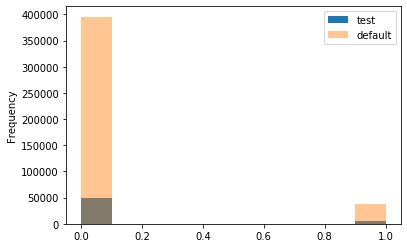

In [368]:
# построим распределение 
test_cr.plot(kind='hist', alpha=1, legend=True, label='test')
default_cr.plot(kind='hist', alpha=0.45, legend=True, label='default');

In [371]:
# проведем Z-test для двух выборок c биномиальным распределением
alpha = 0.05  # уровень статистической значимости

zscore, pvalue = proportions_ztest([sum(test_cr), sum(default_cr)], [len(test_cr), len(default_cr)],
                                   alternative = 'two-sided')
print('zscore = {:.4f}, pvalue = {:.4e}'.format(zscore, pvalue))

if pvalue <= alpha:
    print('Результат теста cтатзначимый.')
    if test_cr.mean() > default_cr.mean():
        print('Удалось увеличить конверсию.')
    else:
        print('Конверсию увеличить не удалось.')
else:
    print('Не удалось отвергнуть нулевую гипотезу о равенстве результатов и получить статзначимый результат.')

zscore = 7.2477, pvalue = 4.2389e-13
Результат теста cтатзначимый.
Удалось увеличить конверсию.


#### Количество добавленных товаров

##### test

In [372]:
test_added

,hit_at,anonymous_id,group,device_type,browser,os,product_added,product_added_cnt,conversion
0,2020-11-26 00:00:19.020000+00:00,64f2ed52-52be-4171-917f-1834c0f736f2,address_first,desktop,Chrome,Linux,0,NaN,0
1,2020-11-26 00:04:16.775000+00:00,48e03311-f213-4b63-b2f9-ff2508b54a03,address_first,desktop,Chrome,Linux,0,NaN,0
2,2020-11-26 00:04:58.764000+00:00,85932680-44e5-4fd2-88dd-03167615f424,address_first,desktop,Chrome,Linux,0,NaN,0
3,2020-11-26 00:05:18.216000+00:00,a4ea1971-f41e-4943-921e-5142c7173ef1,address_first,desktop,Chrome,Linux,0,NaN,0
4,2020-11-26 00:08:29.442000+00:00,3543a788-6bc4-448e-9e97-ac5da585d7a4,address_first,desktop,Chrome,Linux,0,NaN,0
...,...,...,...,...,...,...,...,...,...
54287,2020-12-10 23:51:19.562000+00:00,7f0a4f10-c49c-45a2-bb9e-92b4877b06eb,address_first,mobile,Chrome,Android,0,NaN,0
54288,2020-12-10 23:54:32.255000+00:00,44eda551-929a-4891-b532-0aca11464a28,address_first,desktop,Chrome,Windows,0,NaN,0
54289,2020-12-10 23:56:33.386000+00:00,993e5445-b06f-411a-80ef-818a6cd584d9,address_first,mobile,Samsung Browser,Android,0,NaN,0
54290,2020-12-10 23:57:47.998000+00:00,d4ed11c9-e4e2-4781-bc1b-815bc8ae2608,address_first,mobile,Chrome WebView,Android,0,NaN,0


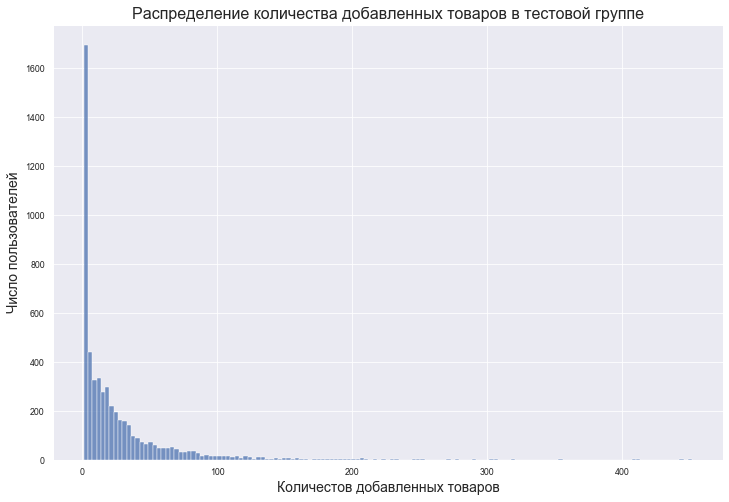

In [465]:
# распределение количества добавленных товаров
plt.figure(figsize=(12, 8))
ax = sns.histplot(data=test_added, x='product_added_cnt')

ax.set_xlabel('Количестов добавленных товаров',fontsize=14)
ax.set_ylabel('Число пользователей',fontsize=14)
ax.set_title('Распределение количества добавленных товаров в тестовой группе', fontsize=16);

plt.savefig('test_cnt.png')

In [440]:
# Прологарифмируем выборку
test_added['product_cnt_log'] = test_added['product_added_cnt'].apply(lambda x: np.log(x))

test_added

,hit_at,anonymous_id,group,device_type,browser,os,product_added,product_added_cnt,conversion,product_cnt_log
0,2020-11-26 00:00:19.020000+00:00,64f2ed52-52be-4171-917f-1834c0f736f2,address_first,desktop,Chrome,Linux,0,NaN,0,NaN
1,2020-11-26 00:04:16.775000+00:00,48e03311-f213-4b63-b2f9-ff2508b54a03,address_first,desktop,Chrome,Linux,0,NaN,0,NaN
2,2020-11-26 00:04:58.764000+00:00,85932680-44e5-4fd2-88dd-03167615f424,address_first,desktop,Chrome,Linux,0,NaN,0,NaN
3,2020-11-26 00:05:18.216000+00:00,a4ea1971-f41e-4943-921e-5142c7173ef1,address_first,desktop,Chrome,Linux,0,NaN,0,NaN
4,2020-11-26 00:08:29.442000+00:00,3543a788-6bc4-448e-9e97-ac5da585d7a4,address_first,desktop,Chrome,Linux,0,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...
54287,2020-12-10 23:51:19.562000+00:00,7f0a4f10-c49c-45a2-bb9e-92b4877b06eb,address_first,mobile,Chrome,Android,0,NaN,0,NaN
54288,2020-12-10 23:54:32.255000+00:00,44eda551-929a-4891-b532-0aca11464a28,address_first,desktop,Chrome,Windows,0,NaN,0,NaN
54289,2020-12-10 23:56:33.386000+00:00,993e5445-b06f-411a-80ef-818a6cd584d9,address_first,mobile,Samsung Browser,Android,0,NaN,0,NaN
54290,2020-12-10 23:57:47.998000+00:00,d4ed11c9-e4e2-4781-bc1b-815bc8ae2608,address_first,mobile,Chrome WebView,Android,0,NaN,0,NaN


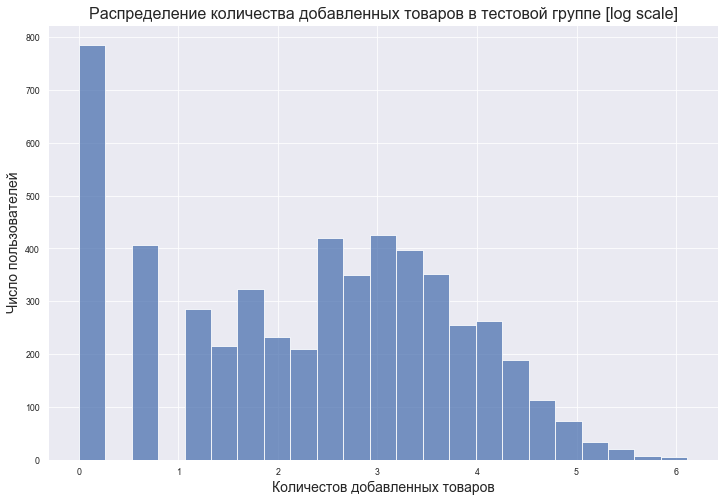

In [466]:
# распределение количества добавленных товаров (после логарифмирования)
plt.figure(figsize=(12, 8))
ax = sns.histplot(data=test_added, x='product_cnt_log')

ax.set_xlabel('Количестов добавленных товаров',fontsize=14)
ax.set_ylabel('Число пользователей',fontsize=14)
ax.set_title('Распределение количества добавленных товаров в тестовой группе [log scale]', fontsize=16);

plt.savefig('test_cnt_log.png')

In [470]:
# выборка значений
test_cnt_log = test_added.product_cnt_log

In [ ]:
# вспомогательный датафрейм
temp_t = test_cnt_log.reset_index()

temp_t = temp_t.assign(group = 'test')

In [533]:
# тест Шапиро-Уилка на нормальность до преобразования
result = st.shapiro(test_added[test_added['product_added_cnt'] >= 0].product_added_cnt.sample(1000, random_state=17))  # sample 1000 для стабильности теста

print('test statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result[1] > alpha:
    print('Распределение нормальное.')
else:
    print('Распределение не является нормальным.')

test statistic = 0.6650, pvalue = 2.0564e-40
Распределение не является нормальным.


In [534]:
# тест Шапиро-Уилка на нормальность после преобразования (логарифмирование)
result = st.shapiro(temp_t[temp_t['product_cnt_log'] >= 0].product_cnt_log.sample(1000, random_state=17))  # sample 1000 для стабильности теста

print('test statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result[1] > alpha:
    print('Распределение нормальное.')
else:
    print('Распределение не является нормальным.')

test statistic = 0.9492, pvalue = 4.5655e-18
Распределение не является нормальным.


##### default

In [476]:
default_added

,hit_at,anonymous_id,group,device_type,browser,os,product_added,product_added_cnt,conversion
0,2020-11-26 00:00:10.318000+00:00,8fe5810d-905c-462d-944b-66921878fa7d,default,mobile,Chrome WebView,Android,0,NaN,0
1,2020-11-26 00:00:17.474000+00:00,3ce00502-94c0-41c8-8165-20ea6d2ecd73,default,mobile,Mobile Safari,iOS,0,NaN,0
2,2020-11-26 00:00:19.951000+00:00,e9030181-192e-4636-9691-2ba4d1eeabb2,default,desktop,Chrome,Windows,0,NaN,0
3,2020-11-26 00:00:24.159000+00:00,20e24ee6-e40e-4f9a-9631-7db36332c734,default,mobile,Samsung Browser,Android,0,NaN,0
4,2020-11-26 00:00:25.857000+00:00,e9480708-34a6-4356-8e65-b39664875cb9,default,mobile,Chrome,Android,0,NaN,0
...,...,...,...,...,...,...,...,...,...
434194,2020-12-10 23:59:18.618000+00:00,5e518207-82fb-48b9-9764-c167e84dc57c,default,desktop,Chrome,Linux,0,NaN,0
434195,2020-12-10 23:59:35.345000+00:00,90b60ec1-4d0e-4fab-8cf0-6c5c128ea5ec,default,mobile,Mobile Safari,iOS,0,NaN,0
434196,2020-12-10 23:59:36.293000+00:00,454c7515-0a58-4822-a431-d271e91da190,default,desktop,Chrome,Linux,0,NaN,0
434197,2020-12-10 23:59:48.461000+00:00,ad4b596b-88d3-41e9-969a-7d988039405b,default,desktop,Chrome,Windows,0,NaN,0


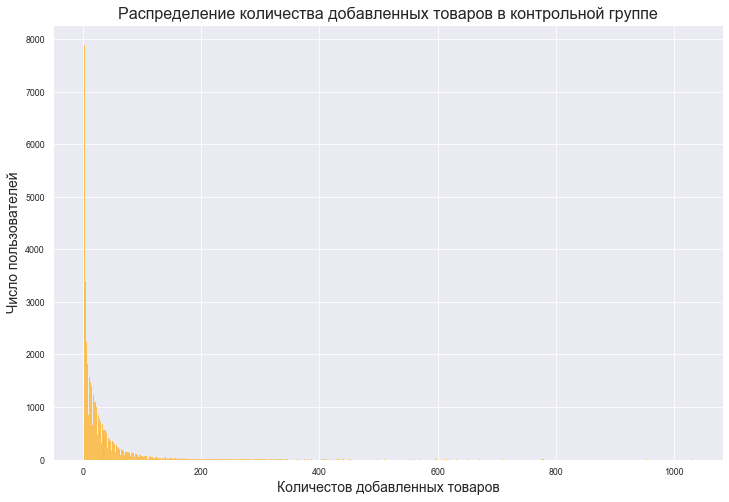

In [484]:
# распределение количества добавленных товаров
plt.figure(figsize=(12, 8))
ax = sns.histplot(data=default_added, x='product_added_cnt', color='orange')

ax.set_xlabel('Количестов добавленных товаров',fontsize=14)
ax.set_ylabel('Число пользователей',fontsize=14)
ax.set_title('Распределение количества добавленных товаров в контрольной группе', fontsize=16);

plt.savefig('default_cnt.png')

In [478]:
# Прологарифмируем выборку
default_added['product_cnt_log'] = default_added['product_added_cnt'].apply(lambda x: np.log(x))

default_added

,hit_at,anonymous_id,group,device_type,browser,os,product_added,product_added_cnt,conversion,product_cnt_log
0,2020-11-26 00:00:10.318000+00:00,8fe5810d-905c-462d-944b-66921878fa7d,default,mobile,Chrome WebView,Android,0,NaN,0,NaN
1,2020-11-26 00:00:17.474000+00:00,3ce00502-94c0-41c8-8165-20ea6d2ecd73,default,mobile,Mobile Safari,iOS,0,NaN,0,NaN
2,2020-11-26 00:00:19.951000+00:00,e9030181-192e-4636-9691-2ba4d1eeabb2,default,desktop,Chrome,Windows,0,NaN,0,NaN
3,2020-11-26 00:00:24.159000+00:00,20e24ee6-e40e-4f9a-9631-7db36332c734,default,mobile,Samsung Browser,Android,0,NaN,0,NaN
4,2020-11-26 00:00:25.857000+00:00,e9480708-34a6-4356-8e65-b39664875cb9,default,mobile,Chrome,Android,0,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...
434194,2020-12-10 23:59:18.618000+00:00,5e518207-82fb-48b9-9764-c167e84dc57c,default,desktop,Chrome,Linux,0,NaN,0,NaN
434195,2020-12-10 23:59:35.345000+00:00,90b60ec1-4d0e-4fab-8cf0-6c5c128ea5ec,default,mobile,Mobile Safari,iOS,0,NaN,0,NaN
434196,2020-12-10 23:59:36.293000+00:00,454c7515-0a58-4822-a431-d271e91da190,default,desktop,Chrome,Linux,0,NaN,0,NaN
434197,2020-12-10 23:59:48.461000+00:00,ad4b596b-88d3-41e9-969a-7d988039405b,default,desktop,Chrome,Windows,0,NaN,0,NaN


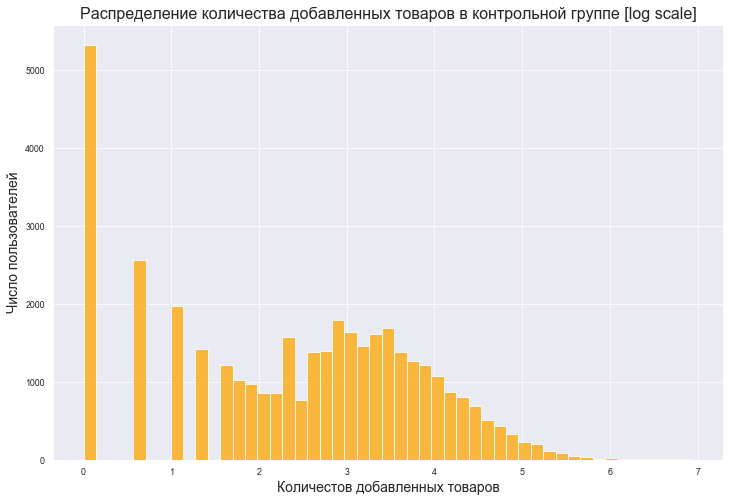

In [485]:
# распределение количества добавленных товаров (после логарифмирования)
plt.figure(figsize=(12, 8))
ax = sns.histplot(data=default_added, x='product_cnt_log', color='orange')

ax.set_xlabel('Количестов добавленных товаров',fontsize=14)
ax.set_ylabel('Число пользователей',fontsize=14)
ax.set_title('Распределение количества добавленных товаров в контрольной группе [log scale]', fontsize=16);

plt.savefig('default_cnt_log.png')

In [480]:
# выборка значений
default_cnt_log = default_added.product_cnt_log

In [ ]:
# вспомогательный датафрейм
temp_d = default_cnt_log.reset_index()
temp_d = temp_d.assign(group = 'default')

In [535]:
# тест Шапиро-Уилка на нормальность до преобразования
result = st.shapiro(default_added[default_added['product_added_cnt'] >= 0].product_added_cnt.sample(1000, random_state=17))  # sample 1000 для стабильности теста

print('test statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result[1] > alpha:
    print('Распределение нормальное.')
else:
    print('Распределение не является нормальным.')

test statistic = 0.6835, pvalue = 1.3262e-39
Распределение не является нормальным.


In [536]:
# тест Шапиро-Уилка на нормальность после преобразования (логарифмирование)
result = st.shapiro(temp_d[temp_d['product_cnt_log'] >= 0].product_cnt_log.sample(1000, random_state=17))  # sample 1000 для стабильности теста

print('test statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result[1] > alpha:
    print('Распределение нормальное.')
else:
    print('Распределение не является нормальным.')

test statistic = 0.9490, pvalue = 4.1008e-18
Распределение не является нормальным.


In [511]:
# объединенный вспомогательнй датафрейм
temp = pd.concat([temp_d, temp_t])

temp

,index,product_cnt_log,group
0,0,NaN,default
1,1,NaN,default
2,2,NaN,default
3,3,NaN,default
4,4,NaN,default
...,...,...,...
54287,54287,NaN,test
54288,54288,NaN,test
54289,54289,NaN,test
54290,54290,NaN,test


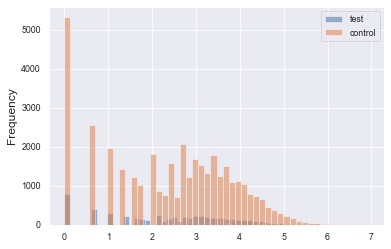

In [494]:
# наложим распределения друг на друга
test_cnt_log.plot(kind='hist', alpha=0.55, legend=True, label='test', bins=50)
default_cnt_log.plot(kind='hist', alpha=0.55, legend=True, label='control', bins=50);

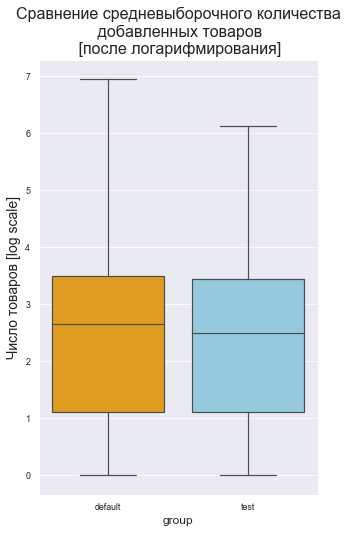

In [655]:
# boxplot распределений
plt.figure(figsize=(5, 8))
my_pal = ['orange', 'skyblue']
ax = sns.boxplot(data=temp, y='product_cnt_log', x='group', palette=my_pal);

ax.set_title('Cравнение средневыборочного количества\n добавленных товаров\n [после логарифмирования]', fontsize=16);
#ax.set_xlabel('Количестов добавленных товаров',fontsize=14)
ax.set_ylabel('Число товаров [log scale]',fontsize=14)


plt.savefig('boxplot_cnt_log2.png');

#### AB-test количество добавленных товаров

In [541]:
# U Mann-Whitneyu проверка двух средних независимых выборок
alpha = 0.05

result = st.mannwhitneyu(temp_d[temp_d['product_cnt_log'] >= 0].product_cnt_log,
                      temp_t[temp_t['product_cnt_log'] >= 0].product_cnt_log,
                      alternative='two-sided')

print('U statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу о равенстве средних двух выборок.')
    if temp_t[temp_t['product_cnt_log'] >= 0].product_cnt_log.mean() >temp_d[temp_d['product_cnt_log'] >= 0].product_cnt_log.mean():
        print('Удалось увеличить количество добавлений товаров в корзину.')
    else:
        print('Количество добавлений товаров в корзину увеличить не удалось.')
else:
    print('У нас не достаточно оснований, чтобы отвергнуть нулевую гипотезу и принять альтернативную.')

U statistic = 107097905.0000, pvalue = 1.5416e-04
Отвергаем нулевую гипотезу о равенстве средних двух выборок.
Количество добавлений товаров в корзину увеличить не удалось.


#### Скорость попадания товара в корзину

##### test

In [552]:
test_lw

,anonymous_id,hit_at,landing_viewed,landing_view_cnt
0,6368eb82-d361-4aca-869e-080f167e3b5f,2020-12-01 00:57:15.357000+00:00,"[2020-12-01 00:57:47.439000+00:00, 2020-12-01 ...",532
1,8da49d4a-48a7-4e27-8a16-5d122c9602c4,2020-12-02 17:14:50.225000+00:00,"[2020-12-08 15:26:04.107000+00:00, 2020-12-08 ...",126
2,43565189-ddcb-4d0e-981c-91eb105ee2aa,2020-12-03 07:43:42.571000+00:00,"[2020-12-10 17:37:24.233000+00:00, 2020-12-11 ...",83
3,f20faf0a-75c6-41d4-a12e-472ce3b923b8,2020-11-27 18:11:49.984000+00:00,"[2020-12-12 19:01:52.862000+00:00, 2020-12-13 ...",47
4,cedad510-b65c-4077-82b2-88b020e62f79,2020-11-26 20:37:53.819000+00:00,"[2020-11-27 06:46:01.309000+00:00, 2020-11-27 ...",38
...,...,...,...,...
23545,6117f53f-ed37-443d-be6d-b5bd1d61088d,2020-11-27 18:24:07.506000+00:00,[2020-11-27 18:24:07.655000+00:00],1
23546,6115517c-bb51-4068-85fb-c64b75638dee,2020-12-03 13:06:01.228000+00:00,[2020-12-03 13:06:01.258000+00:00],1
23547,6114feb3-5192-47ab-a61b-4f45a33646f7,2020-12-03 08:05:17.151000+00:00,[2020-12-03 08:07:15.844000+00:00],1
23548,611386ec-1212-4e3c-8569-61d6ac055e8f,2020-11-26 13:46:18.473000+00:00,[2020-11-26 13:46:18.473000+00:00],1


In [554]:
test_2 = test[['hit_at', 'anonymous_id']]

test_2

,hit_at,anonymous_id
45810,2020-11-26 00:00:19.020000+00:00,64f2ed52-52be-4171-917f-1834c0f736f2
38251,2020-11-26 00:04:16.775000+00:00,48e03311-f213-4b63-b2f9-ff2508b54a03
59377,2020-11-26 00:04:58.764000+00:00,85932680-44e5-4fd2-88dd-03167615f424
43073,2020-11-26 00:05:18.216000+00:00,a4ea1971-f41e-4943-921e-5142c7173ef1
59378,2020-11-26 00:08:29.442000+00:00,3543a788-6bc4-448e-9e97-ac5da585d7a4
...,...,...
127029,2020-12-10 23:51:19.562000+00:00,7f0a4f10-c49c-45a2-bb9e-92b4877b06eb
266369,2020-12-10 23:54:32.255000+00:00,44eda551-929a-4891-b532-0aca11464a28
490622,2020-12-10 23:56:33.386000+00:00,993e5445-b06f-411a-80ef-818a6cd584d9
485423,2020-12-10 23:57:47.998000+00:00,d4ed11c9-e4e2-4781-bc1b-815bc8ae2608


In [557]:
test_2_lw = test_2.merge(landing_v, on='anonymous_id', how='left') \
    .rename(columns={'timestamp': 'landing_time'})

test_2_lw

,hit_at,anonymous_id,landing_time
0,2020-11-26 00:00:19.020000+00:00,64f2ed52-52be-4171-917f-1834c0f736f2,2020-11-26 00:00:19.019000+00:00
1,2020-11-26 00:04:16.775000+00:00,48e03311-f213-4b63-b2f9-ff2508b54a03,2020-11-26 00:04:16.776000+00:00
2,2020-11-26 00:04:58.764000+00:00,85932680-44e5-4fd2-88dd-03167615f424,2020-11-26 00:04:58.765000+00:00
3,2020-11-26 00:05:18.216000+00:00,a4ea1971-f41e-4943-921e-5142c7173ef1,2020-11-26 00:05:18.216000+00:00
4,2020-11-26 00:08:29.442000+00:00,3543a788-6bc4-448e-9e97-ac5da585d7a4,2020-11-26 00:08:29.457000+00:00
...,...,...,...
66297,2020-12-10 23:51:19.562000+00:00,7f0a4f10-c49c-45a2-bb9e-92b4877b06eb,2020-12-10 23:51:19.562000+00:00
66298,2020-12-10 23:54:32.255000+00:00,44eda551-929a-4891-b532-0aca11464a28,NaT
66299,2020-12-10 23:56:33.386000+00:00,993e5445-b06f-411a-80ef-818a6cd584d9,NaT
66300,2020-12-10 23:57:47.998000+00:00,d4ed11c9-e4e2-4781-bc1b-815bc8ae2608,NaT


In [563]:
test2_lw_grouped = test_2_lw.groupby(['anonymous_id', 'landing_time'], as_index=False).agg({'hit_at' : 'count'}) \
    .sort_values(['anonymous_id', 'landing_time'], ascending=True)

test2_lw_grouped

,anonymous_id,landing_time,hit_at
0,0006c4b0-ce48-4294-8027-8f22e4e3a93b,2020-12-09 11:12:35.485000+00:00,1
1,0007e6dd-f368-4108-bd3c-93fd3dc4f880,2020-11-28 09:18:39.728000+00:00,1
2,000aad95-885c-4d32-80c1-c53434a17ac9,2020-11-28 11:03:02.111000+00:00,1
3,000fda14-fac9-45d1-a6b0-5add620ba0d6,2020-12-09 05:53:57.473000+00:00,1
4,000fda14-fac9-45d1-a6b0-5add620ba0d6,2020-12-09 05:54:44.474000+00:00,1
...,...,...,...
35555,fff4b7eb-6454-46f0-a598-9f813b443815,2020-12-08 16:03:08.347000+00:00,1
35556,fff53aa3-cbdd-4f33-bc8f-1b2842a0426b,2020-12-04 04:32:10.076000+00:00,1
35557,fffa7926-b5a3-4533-a737-c6e4f351243b,2020-11-26 15:21:17.315000+00:00,1
35558,fffad60a-648b-418b-8d1b-6e714a828faf,2020-12-03 14:11:10.695000+00:00,1


In [568]:
test2_lw_grouped[test2_lw_grouped.anonymous_id.duplicated(keep=False)== True]

,anonymous_id,landing_time,hit_at
3,000fda14-fac9-45d1-a6b0-5add620ba0d6,2020-12-09 05:53:57.473000+00:00,1
4,000fda14-fac9-45d1-a6b0-5add620ba0d6,2020-12-09 05:54:44.474000+00:00,1
7,00170748-1815-494d-86eb-c95fd8ad0de4,2020-11-26 16:14:58.182000+00:00,1
8,00170748-1815-494d-86eb-c95fd8ad0de4,2020-11-26 16:15:17.144000+00:00,1
9,001de4df-8dc4-4e9e-86a9-d4a9fdae8257,2020-12-10 09:00:13.724000+00:00,1
...,...,...,...
35542,ffd2b302-8ce9-4fa0-b761-5fa2ac611edf,2020-12-03 22:13:25.565000+00:00,1
35548,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:14:35.284000+00:00,1
35549,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:42:08.788000+00:00,1
35550,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:43:21.193000+00:00,1


In [570]:
pd_added_grouped = product_added.reset_index() \
    .groupby(['anonymous_id', 'timestamp'], as_index=False).agg({'index' : 'count'}) \
    .sort_values(['anonymous_id', 'timestamp'], ascending=True)

pd_added_grouped

,anonymous_id,timestamp,index
0,00000782-154a-4159-ab12-6c34b658e375,2020-11-28 07:50:05.580000+00:00,1
1,00000782-154a-4159-ab12-6c34b658e375,2020-11-28 07:50:15.865000+00:00,1
2,00000782-154a-4159-ab12-6c34b658e375,2020-11-29 08:23:16.220000+00:00,1
3,00000782-154a-4159-ab12-6c34b658e375,2020-11-29 08:26:09.465000+00:00,1
4,00000782-154a-4159-ab12-6c34b658e375,2020-11-29 08:26:34.235000+00:00,1
...,...,...,...
1150055,ffff5651-7253-4b44-9d35-95d0cdd89622,2020-12-02 07:39:33.915000+00:00,1
1150056,ffff5651-7253-4b44-9d35-95d0cdd89622,2020-12-02 07:39:41.419000+00:00,1
1150057,ffff5651-7253-4b44-9d35-95d0cdd89622,2020-12-02 07:43:55.574000+00:00,1
1150058,ffff5651-7253-4b44-9d35-95d0cdd89622,2020-12-02 07:44:07.568000+00:00,1


In [572]:
test2_added = test2_lw_grouped.merge(pd_added_grouped, on='anonymous_id', how='left') \
    .rename(columns={'timestamp': 'added_time'})

test2_added

,anonymous_id,landing_time,hit_at,added_time,index
0,0006c4b0-ce48-4294-8027-8f22e4e3a93b,2020-12-09 11:12:35.485000+00:00,1,NaT,NaN
1,0007e6dd-f368-4108-bd3c-93fd3dc4f880,2020-11-28 09:18:39.728000+00:00,1,NaT,NaN
2,000aad95-885c-4d32-80c1-c53434a17ac9,2020-11-28 11:03:02.111000+00:00,1,NaT,NaN
3,000fda14-fac9-45d1-a6b0-5add620ba0d6,2020-12-09 05:53:57.473000+00:00,1,NaT,NaN
4,000fda14-fac9-45d1-a6b0-5add620ba0d6,2020-12-09 05:54:44.474000+00:00,1,NaT,NaN
...,...,...,...,...,...
258725,fff4b7eb-6454-46f0-a598-9f813b443815,2020-12-08 16:03:08.347000+00:00,1,NaT,NaN
258726,fff53aa3-cbdd-4f33-bc8f-1b2842a0426b,2020-12-04 04:32:10.076000+00:00,1,NaT,NaN
258727,fffa7926-b5a3-4533-a737-c6e4f351243b,2020-11-26 15:21:17.315000+00:00,1,NaT,NaN
258728,fffad60a-648b-418b-8d1b-6e714a828faf,2020-12-03 14:11:10.695000+00:00,1,NaT,NaN


In [575]:
test2_added_filt = test2_added[test2_added['added_time'].isna() == False].drop(columns=['hit_at', 'index'])

test2_added_filt

,anonymous_id,landing_time,added_time
5,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156000+00:00,2020-12-09 06:54:33.365000+00:00
6,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156000+00:00,2020-12-09 06:54:38.136000+00:00
7,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156000+00:00,2020-12-09 06:58:49.492000+00:00
8,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156000+00:00,2020-12-09 06:59:52.778000+00:00
9,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156000+00:00,2020-12-09 07:04:32.726000+00:00
...,...,...,...
258714,ffda1621-b553-4b08-89e7-07729ff397c3,2020-12-07 07:39:07.437000+00:00,2020-12-07 11:01:16.555000+00:00
258718,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:14:35.284000+00:00,2020-12-05 07:48:09.183000+00:00
258719,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:42:08.788000+00:00,2020-12-05 07:48:09.183000+00:00
258720,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:43:21.193000+00:00,2020-12-05 07:48:09.183000+00:00


In [577]:
test2_added_grouped = test2_added_filt.reset_index() \
    .groupby(['anonymous_id', 'landing_time', 'added_time'], as_index=False).agg({'index' : 'count'}) \
    .sort_values(['anonymous_id', 'landing_time', 'added_time'], ascending=True)

test2_added_grouped

,anonymous_id,landing_time,added_time,index
0,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156000+00:00,2020-12-09 06:54:33.365000+00:00,1
1,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156000+00:00,2020-12-09 06:54:38.136000+00:00,1
2,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156000+00:00,2020-12-09 06:58:49.492000+00:00,1
3,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156000+00:00,2020-12-09 06:59:52.778000+00:00,1
4,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156000+00:00,2020-12-09 07:04:32.726000+00:00,1
...,...,...,...,...
230172,ffda1621-b553-4b08-89e7-07729ff397c3,2020-12-07 07:39:07.437000+00:00,2020-12-07 11:01:16.555000+00:00,1
230173,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:14:35.284000+00:00,2020-12-05 07:48:09.183000+00:00,1
230174,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:42:08.788000+00:00,2020-12-05 07:48:09.183000+00:00,1
230175,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:43:21.193000+00:00,2020-12-05 07:48:09.183000+00:00,1


In [579]:
test2_added_dd = test2_added_grouped.drop_duplicates(subset=['landing_time']).drop(columns='index')

test2_added_dd

,anonymous_id,landing_time,added_time
0,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156000+00:00,2020-12-09 06:54:33.365000+00:00
7,00292def-6714-49fe-940a-5cfda3cbf84b,2020-12-04 20:15:22.398000+00:00,2020-12-04 20:16:42.658000+00:00
8,0037ebf4-0e14-4880-b6b9-5dec5a70ea66,2020-12-05 06:41:35.454000+00:00,2020-12-05 06:44:56.777000+00:00
37,004aec46-3e7f-4003-bd37-a665d6acd719,2020-12-04 06:33:52.187000+00:00,2020-12-04 06:37:01.533000+00:00
41,004aec46-3e7f-4003-bd37-a665d6acd719,2020-12-04 06:36:07.051000+00:00,2020-12-04 06:37:01.533000+00:00
...,...,...,...
230168,ffda1621-b553-4b08-89e7-07729ff397c3,2020-12-07 07:39:07.437000+00:00,2020-12-07 07:42:38.041000+00:00
230173,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:14:35.284000+00:00,2020-12-05 07:48:09.183000+00:00
230174,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:42:08.788000+00:00,2020-12-05 07:48:09.183000+00:00
230175,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:43:21.193000+00:00,2020-12-05 07:48:09.183000+00:00


In [584]:
test2_added_dd['time_delta'] = test2_added_dd['added_time'] - test2_added_dd['landing_time']

test2_added_dd

,anonymous_id,landing_time,added_time,time_delta
0,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156000+00:00,2020-12-09 06:54:33.365000+00:00,0 days 00:01:58.209000
7,00292def-6714-49fe-940a-5cfda3cbf84b,2020-12-04 20:15:22.398000+00:00,2020-12-04 20:16:42.658000+00:00,0 days 00:01:20.260000
8,0037ebf4-0e14-4880-b6b9-5dec5a70ea66,2020-12-05 06:41:35.454000+00:00,2020-12-05 06:44:56.777000+00:00,0 days 00:03:21.323000
37,004aec46-3e7f-4003-bd37-a665d6acd719,2020-12-04 06:33:52.187000+00:00,2020-12-04 06:37:01.533000+00:00,0 days 00:03:09.346000
41,004aec46-3e7f-4003-bd37-a665d6acd719,2020-12-04 06:36:07.051000+00:00,2020-12-04 06:37:01.533000+00:00,0 days 00:00:54.482000
...,...,...,...,...
230168,ffda1621-b553-4b08-89e7-07729ff397c3,2020-12-07 07:39:07.437000+00:00,2020-12-07 07:42:38.041000+00:00,0 days 00:03:30.604000
230173,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:14:35.284000+00:00,2020-12-05 07:48:09.183000+00:00,0 days 00:33:33.899000
230174,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:42:08.788000+00:00,2020-12-05 07:48:09.183000+00:00,0 days 00:06:00.395000
230175,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:43:21.193000+00:00,2020-12-05 07:48:09.183000+00:00,0 days 00:04:47.990000


In [590]:
test2_added_dd['seconds'] = test2_added_dd.time_delta.dt.total_seconds()

test2_added_dd

,anonymous_id,landing_time,added_time,time_delta,seconds
0,0015e7d0-b4be-4fef-918c-668cc4bad1ea,2020-12-09 06:52:35.156000+00:00,2020-12-09 06:54:33.365000+00:00,0 days 00:01:58.209000,118.209
7,00292def-6714-49fe-940a-5cfda3cbf84b,2020-12-04 20:15:22.398000+00:00,2020-12-04 20:16:42.658000+00:00,0 days 00:01:20.260000,80.260
8,0037ebf4-0e14-4880-b6b9-5dec5a70ea66,2020-12-05 06:41:35.454000+00:00,2020-12-05 06:44:56.777000+00:00,0 days 00:03:21.323000,201.323
37,004aec46-3e7f-4003-bd37-a665d6acd719,2020-12-04 06:33:52.187000+00:00,2020-12-04 06:37:01.533000+00:00,0 days 00:03:09.346000,189.346
41,004aec46-3e7f-4003-bd37-a665d6acd719,2020-12-04 06:36:07.051000+00:00,2020-12-04 06:37:01.533000+00:00,0 days 00:00:54.482000,54.482
...,...,...,...,...,...
230168,ffda1621-b553-4b08-89e7-07729ff397c3,2020-12-07 07:39:07.437000+00:00,2020-12-07 07:42:38.041000+00:00,0 days 00:03:30.604000,210.604
230173,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:14:35.284000+00:00,2020-12-05 07:48:09.183000+00:00,0 days 00:33:33.899000,2013.899
230174,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:42:08.788000+00:00,2020-12-05 07:48:09.183000+00:00,0 days 00:06:00.395000,360.395
230175,ffe20f8d-0fe9-4c3a-925f-60ed10b2c2d0,2020-12-05 07:43:21.193000+00:00,2020-12-05 07:48:09.183000+00:00,0 days 00:04:47.990000,287.990


In [598]:
test2_dd_ss = test2_added_dd[test2_added_dd['seconds'] > 0].sort_values('seconds')

test2_dd_ss

,anonymous_id,landing_time,added_time,time_delta,seconds
149366,b178fb5c-68c3-49f7-90a2-dd1b98eb0df2,2020-12-10 09:14:29.225000+00:00,2020-12-10 09:14:47.224000+00:00,0 days 00:00:17.999000,17.999
197535,da99c948-dce1-40fd-bfa8-7c3e26d509ec,2020-11-29 16:10:44.990000+00:00,2020-11-29 16:11:03.355000+00:00,0 days 00:00:18.365000,18.365
59901,470d144c-72ea-4032-8ece-9a9fbf757577,2020-12-06 19:11:44.602000+00:00,2020-12-06 19:12:04.351000+00:00,0 days 00:00:19.749000,19.749
33553,2dc99513-1442-4611-bed2-9920bb0ca8b8,2020-12-07 16:10:33.651000+00:00,2020-12-07 16:10:54.444000+00:00,0 days 00:00:20.793000,20.793
105371,7f4d48bc-3fd1-49fc-a103-b4736d4ceb08,2020-11-26 21:11:09.139000+00:00,2020-11-26 21:11:29.966000+00:00,0 days 00:00:20.827000,20.827
...,...,...,...,...,...
8047,0b495c6f-9bad-485d-89ce-2573febea43f,2020-11-26 12:44:19.713000+00:00,2020-12-17 11:40:18.720000+00:00,20 days 22:55:59.007000,1810559.007
8031,0b495c6f-9bad-485d-89ce-2573febea43f,2020-11-26 12:43:51.492000+00:00,2020-12-17 11:40:18.720000+00:00,20 days 22:56:27.228000,1810587.228
227457,fb0cd8bb-9301-4068-8d0f-e04d2ff08a06,2020-11-26 06:49:39.567000+00:00,2020-12-17 08:43:46.347000+00:00,21 days 01:54:06.780000,1821246.780
123574,91e40c7f-df50-40f4-b53a-89b3ca799049,2020-11-26 05:22:51.483000+00:00,2020-12-17 09:01:35.168000+00:00,21 days 03:38:43.685000,1827523.685


In [599]:
test2_dd_ss.seconds.describe()

count    4.727000e+03
mean     8.180376e+04
std      2.405339e+05
min      1.799900e+01
25%      1.537050e+02
50%      3.401480e+02
75%      2.068713e+03
max      1.837060e+06
Name: seconds, dtype: float64

In [601]:
# подсчет межквартильного интервала
q1, q3, iqr = iq_range(test2_dd_ss, 'seconds')

In [602]:
# убираем выбросы
test2_dd_ss_f = test2_dd_ss.query('(@q1 - 1.5*@iqr) <= seconds <= (@q3 + 1.5*@iqr)')
test2_dd_ss_f

,anonymous_id,landing_time,added_time,time_delta,seconds
149366,b178fb5c-68c3-49f7-90a2-dd1b98eb0df2,2020-12-10 09:14:29.225000+00:00,2020-12-10 09:14:47.224000+00:00,0 days 00:00:17.999000,17.999
197535,da99c948-dce1-40fd-bfa8-7c3e26d509ec,2020-11-29 16:10:44.990000+00:00,2020-11-29 16:11:03.355000+00:00,0 days 00:00:18.365000,18.365
59901,470d144c-72ea-4032-8ece-9a9fbf757577,2020-12-06 19:11:44.602000+00:00,2020-12-06 19:12:04.351000+00:00,0 days 00:00:19.749000,19.749
33553,2dc99513-1442-4611-bed2-9920bb0ca8b8,2020-12-07 16:10:33.651000+00:00,2020-12-07 16:10:54.444000+00:00,0 days 00:00:20.793000,20.793
105371,7f4d48bc-3fd1-49fc-a103-b4736d4ceb08,2020-11-26 21:11:09.139000+00:00,2020-11-26 21:11:29.966000+00:00,0 days 00:00:20.827000,20.827
...,...,...,...,...,...
162102,be7c47d6-9cf2-4bd3-9b7c-c2ecf1886428,2020-12-02 11:45:46.099000+00:00,2020-12-02 13:02:49.680000+00:00,0 days 01:17:03.581000,4623.581
215172,ec173cdd-4abe-4031-b19c-b4c910a40f54,2020-11-29 10:29:17.535000+00:00,2020-11-29 11:48:19.541000+00:00,0 days 01:19:02.006000,4742.006
120787,8ce6327e-19a9-4705-ba22-735e32583460,2020-12-07 12:47:01.342000+00:00,2020-12-07 14:06:53.408000+00:00,0 days 01:19:52.066000,4792.066
143378,ad2c944b-6925-4d8e-b10b-f65e10912f56,2020-12-09 08:11:05.522000+00:00,2020-12-09 09:31:42.930000+00:00,0 days 01:20:37.408000,4837.408


In [606]:
test2_dd_ss_f.seconds.describe()

count    3696.000000
mean      476.491373
std       680.219026
min        17.999000
25%       127.690750
50%       233.667500
75%       488.093750
max      4861.817000
Name: seconds, dtype: float64

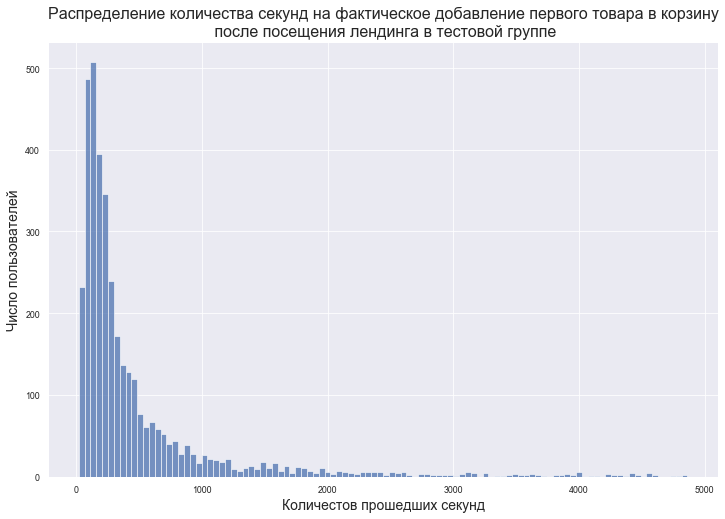

In [628]:
# распределение секунд на фактическое добавление первого товара в корзину после посещения лендинга
plt.figure(figsize=(12, 8))
ax = sns.histplot(data=test2_dd_ss_f, x='seconds')

ax.set_xlabel('Количестов прошедших секунд',fontsize=14)
ax.set_ylabel('Число пользователей',fontsize=14)
ax.set_title('Распределение количества секунд на фактическое добавление первого товара в корзину\n после посещения лендинга в тестовой группе', fontsize=16);

plt.savefig('test_seconds.png')

In [640]:
# тест Шапиро-Уилка на нормальность
result = st.shapiro(test2_dd_ss_f.seconds.sample(1000, random_state=17))  # sample 1000 для стабильности теста

print('test statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result[1] > alpha:
    print('Распределение нормальное.')
else:
    print('Распределение не является нормальным.')

test statistic = 0.5873, pvalue = 1.8357e-43
Распределение не является нормальным.


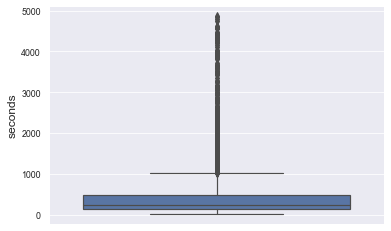

In [604]:
sns.boxplot(data=test2_dd_ss_f, y='seconds')

##### default

In [607]:
default_2 = default[['hit_at', 'anonymous_id']]

default_2

,hit_at,anonymous_id
467677,2020-11-26 00:00:10.318000+00:00,8fe5810d-905c-462d-944b-66921878fa7d
432135,2020-11-26 00:00:17.474000+00:00,3ce00502-94c0-41c8-8165-20ea6d2ecd73
250308,2020-11-26 00:00:19.951000+00:00,e9030181-192e-4636-9691-2ba4d1eeabb2
489342,2020-11-26 00:00:24.159000+00:00,20e24ee6-e40e-4f9a-9631-7db36332c734
144584,2020-11-26 00:00:25.857000+00:00,e9480708-34a6-4356-8e65-b39664875cb9
...,...,...
30732,2020-12-10 23:59:18.618000+00:00,5e518207-82fb-48b9-9764-c167e84dc57c
430450,2020-12-10 23:59:35.345000+00:00,90b60ec1-4d0e-4fab-8cf0-6c5c128ea5ec
35510,2020-12-10 23:59:36.293000+00:00,454c7515-0a58-4822-a431-d271e91da190
199014,2020-12-10 23:59:48.461000+00:00,ad4b596b-88d3-41e9-969a-7d988039405b


In [608]:
default_2_lw = default_2.merge(landing_v, on='anonymous_id', how='left') \
    .rename(columns={'timestamp': 'landing_time'})

default_2_lw

,hit_at,anonymous_id,landing_time
0,2020-11-26 00:00:10.318000+00:00,8fe5810d-905c-462d-944b-66921878fa7d,NaT
1,2020-11-26 00:00:17.474000+00:00,3ce00502-94c0-41c8-8165-20ea6d2ecd73,NaT
2,2020-11-26 00:00:19.951000+00:00,e9030181-192e-4636-9691-2ba4d1eeabb2,NaT
3,2020-11-26 00:00:24.159000+00:00,20e24ee6-e40e-4f9a-9631-7db36332c734,2020-11-26 00:00:23.992000+00:00
4,2020-11-26 00:00:25.857000+00:00,e9480708-34a6-4356-8e65-b39664875cb9,2020-11-26 00:00:25.888000+00:00
...,...,...,...
552143,2020-12-10 23:59:18.618000+00:00,5e518207-82fb-48b9-9764-c167e84dc57c,2020-12-10 23:59:18.603000+00:00
552144,2020-12-10 23:59:35.345000+00:00,90b60ec1-4d0e-4fab-8cf0-6c5c128ea5ec,NaT
552145,2020-12-10 23:59:36.293000+00:00,454c7515-0a58-4822-a431-d271e91da190,2020-12-10 23:59:36.278000+00:00
552146,2020-12-10 23:59:48.461000+00:00,ad4b596b-88d3-41e9-969a-7d988039405b,NaT


In [609]:
default2_lw_grouped = default_2_lw.groupby(['anonymous_id', 'landing_time'], as_index=False).agg({'hit_at' : 'count'}) \
    .sort_values(['anonymous_id', 'landing_time'], ascending=True)

default2_lw_grouped

,anonymous_id,landing_time,hit_at
0,00001104-4c72-4f48-bb8c-ace2ded63f8b,2020-12-05 10:01:51.305000+00:00,1
1,00007575-88d6-4acc-9940-e9ccb8358dca,2020-12-08 11:07:39.962000+00:00,1
2,00016e45-138b-401e-9eac-78b92d48c6c4,2020-12-03 13:12:37.952000+00:00,1
3,0001814e-5cf7-4d23-bc95-4630d9152fc1,2020-12-02 16:03:37.548000+00:00,1
4,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787000+00:00,1
...,...,...,...
305129,fffedf6a-7be6-4313-a0d9-ff87463ba6e8,2020-12-05 14:54:01.768000+00:00,1
305130,fffee334-8e5d-4923-b97e-c3ebb060d70b,2020-12-04 19:15:55.857000+00:00,1
305131,fffee334-8e5d-4923-b97e-c3ebb060d70b,2020-12-10 10:47:30.204000+00:00,1
305132,ffff53e1-df50-43dd-a1d3-c2e34271920b,2020-12-07 06:11:38.610000+00:00,1


In [610]:
default2_lw_grouped[default2_lw_grouped.anonymous_id.duplicated(keep=False)== True]

,anonymous_id,landing_time,hit_at
9,0002d40b-12e4-4729-8065-a2b9613c1c6d,2020-12-02 07:36:39.490000+00:00,1
10,0002d40b-12e4-4729-8065-a2b9613c1c6d,2020-12-02 07:37:14.549000+00:00,1
11,0002d40b-12e4-4729-8065-a2b9613c1c6d,2020-12-02 07:37:45.927000+00:00,1
16,000544b6-143b-4c9c-a2eb-d4e99fb4b89f,2020-12-07 20:44:21.678000+00:00,1
17,000544b6-143b-4c9c-a2eb-d4e99fb4b89f,2020-12-10 01:49:21.899000+00:00,1
...,...,...,...
305124,fffe5596-010c-4987-99e3-c74f17d5bdc6,2020-12-01 15:32:02.754000+00:00,1
305125,fffe5596-010c-4987-99e3-c74f17d5bdc6,2020-12-01 15:33:40.348000+00:00,1
305126,fffe5596-010c-4987-99e3-c74f17d5bdc6,2020-12-01 15:37:37.887000+00:00,1
305130,fffee334-8e5d-4923-b97e-c3ebb060d70b,2020-12-04 19:15:55.857000+00:00,1


In [570]:
pd_added_grouped = product_added.reset_index() \
    .groupby(['anonymous_id', 'timestamp'], as_index=False).agg({'index' : 'count'}) \
    .sort_values(['anonymous_id', 'timestamp'], ascending=True)

pd_added_grouped

,anonymous_id,timestamp,index
0,00000782-154a-4159-ab12-6c34b658e375,2020-11-28 07:50:05.580000+00:00,1
1,00000782-154a-4159-ab12-6c34b658e375,2020-11-28 07:50:15.865000+00:00,1
2,00000782-154a-4159-ab12-6c34b658e375,2020-11-29 08:23:16.220000+00:00,1
3,00000782-154a-4159-ab12-6c34b658e375,2020-11-29 08:26:09.465000+00:00,1
4,00000782-154a-4159-ab12-6c34b658e375,2020-11-29 08:26:34.235000+00:00,1
...,...,...,...
1150055,ffff5651-7253-4b44-9d35-95d0cdd89622,2020-12-02 07:39:33.915000+00:00,1
1150056,ffff5651-7253-4b44-9d35-95d0cdd89622,2020-12-02 07:39:41.419000+00:00,1
1150057,ffff5651-7253-4b44-9d35-95d0cdd89622,2020-12-02 07:43:55.574000+00:00,1
1150058,ffff5651-7253-4b44-9d35-95d0cdd89622,2020-12-02 07:44:07.568000+00:00,1


In [611]:
default2_added = default2_lw_grouped.merge(pd_added_grouped, on='anonymous_id', how='left') \
    .rename(columns={'timestamp': 'added_time'})

default2_added

,anonymous_id,landing_time,hit_at,added_time,index
0,00001104-4c72-4f48-bb8c-ace2ded63f8b,2020-12-05 10:01:51.305000+00:00,1,NaT,NaN
1,00007575-88d6-4acc-9940-e9ccb8358dca,2020-12-08 11:07:39.962000+00:00,1,NaT,NaN
2,00016e45-138b-401e-9eac-78b92d48c6c4,2020-12-03 13:12:37.952000+00:00,1,NaT,NaN
3,0001814e-5cf7-4d23-bc95-4630d9152fc1,2020-12-02 16:03:37.548000+00:00,1,NaT,NaN
4,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787000+00:00,1,2020-12-01 08:26:17.260000+00:00,1.0
...,...,...,...,...,...
2138927,fffedf6a-7be6-4313-a0d9-ff87463ba6e8,2020-12-05 14:54:01.768000+00:00,1,2020-12-13 14:57:32.371000+00:00,1.0
2138928,fffee334-8e5d-4923-b97e-c3ebb060d70b,2020-12-04 19:15:55.857000+00:00,1,NaT,NaN
2138929,fffee334-8e5d-4923-b97e-c3ebb060d70b,2020-12-10 10:47:30.204000+00:00,1,NaT,NaN
2138930,ffff53e1-df50-43dd-a1d3-c2e34271920b,2020-12-07 06:11:38.610000+00:00,1,NaT,NaN


In [612]:
default2_added_filt = default2_added[default2_added['added_time'].isna() == False].drop(columns=['hit_at', 'index'])

default2_added_filt

,anonymous_id,landing_time,added_time
4,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787000+00:00,2020-12-01 08:26:17.260000+00:00
5,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787000+00:00,2020-12-01 08:26:30.751000+00:00
6,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787000+00:00,2020-12-01 08:26:42.996000+00:00
7,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787000+00:00,2020-12-01 08:27:14.090000+00:00
8,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787000+00:00,2020-12-01 08:27:16.127000+00:00
...,...,...,...
2138923,fffedf6a-7be6-4313-a0d9-ff87463ba6e8,2020-12-05 14:54:01.768000+00:00,2020-12-13 14:51:49.327000+00:00
2138924,fffedf6a-7be6-4313-a0d9-ff87463ba6e8,2020-12-05 14:54:01.768000+00:00,2020-12-13 14:54:43.140000+00:00
2138925,fffedf6a-7be6-4313-a0d9-ff87463ba6e8,2020-12-05 14:54:01.768000+00:00,2020-12-13 14:55:38.131000+00:00
2138926,fffedf6a-7be6-4313-a0d9-ff87463ba6e8,2020-12-05 14:54:01.768000+00:00,2020-12-13 14:57:30.738000+00:00


In [613]:
default2_added_grouped = default2_added_filt.reset_index() \
    .groupby(['anonymous_id', 'landing_time', 'added_time'], as_index=False).agg({'index' : 'count'}) \
    .sort_values(['anonymous_id', 'landing_time', 'added_time'], ascending=True)

default2_added_grouped

,anonymous_id,landing_time,added_time,index
0,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787000+00:00,2020-12-01 08:26:17.260000+00:00,1
1,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787000+00:00,2020-12-01 08:26:30.751000+00:00,1
2,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787000+00:00,2020-12-01 08:26:42.996000+00:00,1
3,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787000+00:00,2020-12-01 08:27:14.090000+00:00,1
4,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787000+00:00,2020-12-01 08:27:16.127000+00:00,1
...,...,...,...,...
1884634,fffedf6a-7be6-4313-a0d9-ff87463ba6e8,2020-12-05 14:54:01.768000+00:00,2020-12-13 14:51:49.327000+00:00,1
1884635,fffedf6a-7be6-4313-a0d9-ff87463ba6e8,2020-12-05 14:54:01.768000+00:00,2020-12-13 14:54:43.140000+00:00,1
1884636,fffedf6a-7be6-4313-a0d9-ff87463ba6e8,2020-12-05 14:54:01.768000+00:00,2020-12-13 14:55:38.131000+00:00,1
1884637,fffedf6a-7be6-4313-a0d9-ff87463ba6e8,2020-12-05 14:54:01.768000+00:00,2020-12-13 14:57:30.738000+00:00,1


In [614]:
default2_added_dd = default2_added_grouped.drop_duplicates(subset=['landing_time']).drop(columns='index')

default2_added_dd

,anonymous_id,landing_time,added_time
0,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787000+00:00,2020-12-01 08:26:17.260000+00:00
20,0003ca8f-bb3f-4954-84c7-1fbf2353a454,2020-11-27 14:21:08.794000+00:00,2020-11-27 15:36:24.140000+00:00
29,000cca0e-514d-42fd-ba72-ec3b3917732f,2020-11-27 07:51:07.120000+00:00,2020-11-27 07:59:17.560000+00:00
30,001197b2-8203-476a-8494-bbb11ee2a184,2020-11-29 08:06:16.163000+00:00,2020-11-29 08:30:44.518000+00:00
76,00179381-fef4-4126-b3d4-51d3c668ff5d,2020-12-04 23:13:50.538000+00:00,2020-12-04 23:16:08.027000+00:00
...,...,...,...
1884465,ffede928-c305-44d9-9c4b-6f04f0f2438f,2020-11-27 07:17:36.349000+00:00,2020-11-27 07:24:16.798000+00:00
1884467,fff6349b-c93d-4933-9925-6ff7d27c873e,2020-11-29 14:09:55.347000+00:00,2020-11-26 03:02:44.540000+00:00
1884477,fff6349b-c93d-4933-9925-6ff7d27c873e,2020-12-10 08:15:20.968000+00:00,2020-11-26 03:02:44.540000+00:00
1884487,fffbbed0-9af0-436d-b6de-4d530c9f7112,2020-12-06 12:54:19.526000+00:00,2020-12-06 14:09:21.552000+00:00


In [615]:
default2_added_dd['time_delta'] = default2_added_dd['added_time'] - default2_added_dd['landing_time']

default2_added_dd

,anonymous_id,landing_time,added_time,time_delta
0,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787000+00:00,2020-12-01 08:26:17.260000+00:00,0 days 00:01:25.473000
20,0003ca8f-bb3f-4954-84c7-1fbf2353a454,2020-11-27 14:21:08.794000+00:00,2020-11-27 15:36:24.140000+00:00,0 days 01:15:15.346000
29,000cca0e-514d-42fd-ba72-ec3b3917732f,2020-11-27 07:51:07.120000+00:00,2020-11-27 07:59:17.560000+00:00,0 days 00:08:10.440000
30,001197b2-8203-476a-8494-bbb11ee2a184,2020-11-29 08:06:16.163000+00:00,2020-11-29 08:30:44.518000+00:00,0 days 00:24:28.355000
76,00179381-fef4-4126-b3d4-51d3c668ff5d,2020-12-04 23:13:50.538000+00:00,2020-12-04 23:16:08.027000+00:00,0 days 00:02:17.489000
...,...,...,...,...
1884465,ffede928-c305-44d9-9c4b-6f04f0f2438f,2020-11-27 07:17:36.349000+00:00,2020-11-27 07:24:16.798000+00:00,0 days 00:06:40.449000
1884467,fff6349b-c93d-4933-9925-6ff7d27c873e,2020-11-29 14:09:55.347000+00:00,2020-11-26 03:02:44.540000+00:00,-4 days +12:52:49.193000
1884477,fff6349b-c93d-4933-9925-6ff7d27c873e,2020-12-10 08:15:20.968000+00:00,2020-11-26 03:02:44.540000+00:00,-15 days +18:47:23.572000
1884487,fffbbed0-9af0-436d-b6de-4d530c9f7112,2020-12-06 12:54:19.526000+00:00,2020-12-06 14:09:21.552000+00:00,0 days 01:15:02.026000


In [616]:
default2_added_dd['seconds'] = default2_added_dd.time_delta.dt.total_seconds()

default2_added_dd

,anonymous_id,landing_time,added_time,time_delta,seconds
0,00021d91-c65e-4049-9ae1-7d64702c8c12,2020-12-01 08:24:51.787000+00:00,2020-12-01 08:26:17.260000+00:00,0 days 00:01:25.473000,85.473
20,0003ca8f-bb3f-4954-84c7-1fbf2353a454,2020-11-27 14:21:08.794000+00:00,2020-11-27 15:36:24.140000+00:00,0 days 01:15:15.346000,4515.346
29,000cca0e-514d-42fd-ba72-ec3b3917732f,2020-11-27 07:51:07.120000+00:00,2020-11-27 07:59:17.560000+00:00,0 days 00:08:10.440000,490.440
30,001197b2-8203-476a-8494-bbb11ee2a184,2020-11-29 08:06:16.163000+00:00,2020-11-29 08:30:44.518000+00:00,0 days 00:24:28.355000,1468.355
76,00179381-fef4-4126-b3d4-51d3c668ff5d,2020-12-04 23:13:50.538000+00:00,2020-12-04 23:16:08.027000+00:00,0 days 00:02:17.489000,137.489
...,...,...,...,...,...
1884465,ffede928-c305-44d9-9c4b-6f04f0f2438f,2020-11-27 07:17:36.349000+00:00,2020-11-27 07:24:16.798000+00:00,0 days 00:06:40.449000,400.449
1884467,fff6349b-c93d-4933-9925-6ff7d27c873e,2020-11-29 14:09:55.347000+00:00,2020-11-26 03:02:44.540000+00:00,-4 days +12:52:49.193000,-299230.807
1884477,fff6349b-c93d-4933-9925-6ff7d27c873e,2020-12-10 08:15:20.968000+00:00,2020-11-26 03:02:44.540000+00:00,-15 days +18:47:23.572000,-1228356.428
1884487,fffbbed0-9af0-436d-b6de-4d530c9f7112,2020-12-06 12:54:19.526000+00:00,2020-12-06 14:09:21.552000+00:00,0 days 01:15:02.026000,4502.026


In [617]:
default2_dd_ss = default2_added_dd[default2_added_dd['seconds'] > 0].sort_values('seconds')

default2_dd_ss

,anonymous_id,landing_time,added_time,time_delta,seconds
833744,6f751329-6ef7-4c68-b252-0c2c66d21cad,2020-12-01 18:54:07.506000+00:00,2020-12-01 18:54:17.710000+00:00,0 days 00:00:10.204000,10.204
317451,21c925b0-5751-4e5a-b572-75101faf612b,2020-12-04 19:35:06.070000+00:00,2020-12-04 19:35:16.288000+00:00,0 days 00:00:10.218000,10.218
929655,7b69588f-4f61-4abc-a026-4a3fb4ff84e3,2020-11-30 07:29:05.323000+00:00,2020-11-30 07:29:15.696000+00:00,0 days 00:00:10.373000,10.373
317294,21c925b0-5751-4e5a-b572-75101faf612b,2020-12-04 19:35:05.309000+00:00,2020-12-04 19:35:16.288000+00:00,0 days 00:00:10.979000,10.979
317137,21c925b0-5751-4e5a-b572-75101faf612b,2020-12-04 19:35:04.238000+00:00,2020-12-04 19:35:16.288000+00:00,0 days 00:00:12.050000,12.050
...,...,...,...,...,...
522384,41f56239-b76c-4a96-a0bd-db2a55130a0a,2020-11-27 02:44:25.985000+00:00,2020-12-17 16:15:01.703000+00:00,20 days 13:30:35.718000,1776635.718
1264532,a7741d69-fd9d-41c0-9f8f-2568eebd777c,2020-11-26 05:59:27.243000+00:00,2020-12-17 06:15:46.884000+00:00,21 days 00:16:19.641000,1815379.641
1264505,a7741d69-fd9d-41c0-9f8f-2568eebd777c,2020-11-26 05:58:22.055000+00:00,2020-12-17 06:15:46.884000+00:00,21 days 00:17:24.829000,1815444.829
1264478,a7741d69-fd9d-41c0-9f8f-2568eebd777c,2020-11-26 05:57:55.037000+00:00,2020-12-17 06:15:46.884000+00:00,21 days 00:17:51.847000,1815471.847


In [618]:
default2_dd_ss.seconds.describe()

count    3.480800e+04
mean     7.646313e+04
std      2.287607e+05
min      1.020400e+01
25%      1.927970e+02
50%      4.254250e+02
75%      2.381220e+03
max      1.848756e+06
Name: seconds, dtype: float64

In [619]:
# подсчет межквартильного интервала
q1, q3, iqr = iq_range(default2_dd_ss, 'seconds')

In [620]:
# убираем выбросы
default2_dd_ss_f = default2_dd_ss.query('(@q1 - 1.5*@iqr) <= seconds <= (@q3 + 1.5*@iqr)')
default2_dd_ss_f

,anonymous_id,landing_time,added_time,time_delta,seconds
833744,6f751329-6ef7-4c68-b252-0c2c66d21cad,2020-12-01 18:54:07.506000+00:00,2020-12-01 18:54:17.710000+00:00,0 days 00:00:10.204000,10.204
317451,21c925b0-5751-4e5a-b572-75101faf612b,2020-12-04 19:35:06.070000+00:00,2020-12-04 19:35:16.288000+00:00,0 days 00:00:10.218000,10.218
929655,7b69588f-4f61-4abc-a026-4a3fb4ff84e3,2020-11-30 07:29:05.323000+00:00,2020-11-30 07:29:15.696000+00:00,0 days 00:00:10.373000,10.373
317294,21c925b0-5751-4e5a-b572-75101faf612b,2020-12-04 19:35:05.309000+00:00,2020-12-04 19:35:16.288000+00:00,0 days 00:00:10.979000,10.979
317137,21c925b0-5751-4e5a-b572-75101faf612b,2020-12-04 19:35:04.238000+00:00,2020-12-04 19:35:16.288000+00:00,0 days 00:00:12.050000,12.050
...,...,...,...,...,...
239127,1617e95a-3f75-4cc8-9528-5a7b4aac276b,2020-12-01 21:06:39.638000+00:00,2020-12-01 22:40:46.442000+00:00,0 days 01:34:06.804000,5646.804
1170794,9b10df88-4c2e-4751-ba55-917d291f9b52,2020-12-06 07:48:44.482000+00:00,2020-12-06 09:22:51.419000+00:00,0 days 01:34:06.937000,5646.937
1112769,9579b2e7-5b04-4614-99ae-aa23644cf7bc,2020-12-07 06:07:07.341000+00:00,2020-12-07 07:41:20.075000+00:00,0 days 01:34:12.734000,5652.734
1603916,d8cc10a1-9ce0-4fd2-a869-acef87d99d46,2020-12-01 11:59:11.047000+00:00,2020-12-01 13:33:25.440000+00:00,0 days 01:34:14.393000,5654.393


In [621]:
default2_dd_ss_f.seconds.describe()

count    27434.000000
mean       595.986021
std        843.461931
min         10.204000
25%        161.250750
50%        300.346000
75%        613.992750
max       5658.937000
Name: seconds, dtype: float64

In [ ]:
plt.plot()

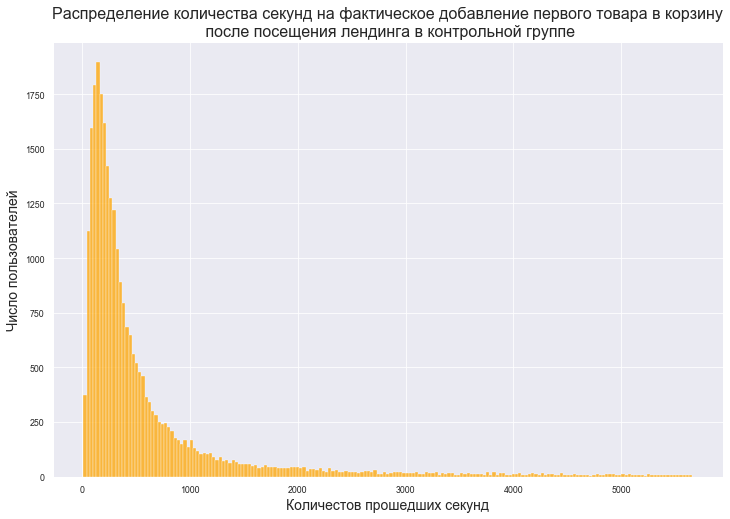

In [627]:
# распределение секунд на фактическое добавление первого товара в корзину после посещения лендинга
plt.figure(figsize=(12, 8))
ax = sns.histplot(data=default2_dd_ss_f, x='seconds', color='orange')

ax.set_xlabel('Количестов прошедших секунд',fontsize=14)
ax.set_ylabel('Число пользователей',fontsize=14)
ax.set_title('Распределение количества секунд на фактическое добавление первого товара в корзину\n после посещения лендинга в контрольной группе', fontsize=16);

plt.savefig('default_seconds.png')

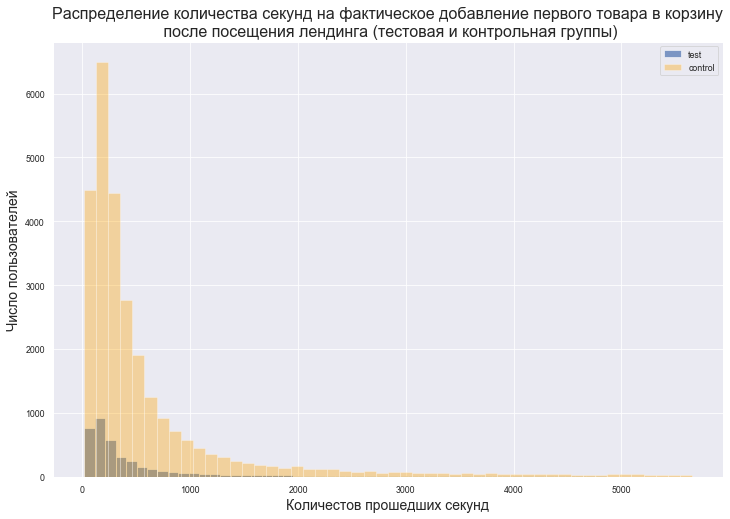

In [638]:
# наложим распределения друг на друга
plt.figure(figsize=(12, 8))
test2_dd_ss_f.seconds.plot(kind='hist', alpha=0.7, legend=True, label='test', bins=50)
default2_dd_ss_f.seconds.plot(kind='hist', alpha=0.35, legend=True, label='control', bins=50, color='orange');

plt.xlabel('Количестов прошедших секунд',fontsize=14)
plt.ylabel('Число пользователей',fontsize=14)
plt.title('Распределение количества секунд на фактическое добавление первого товара в корзину\n после посещения лендинга (тестовая и контрольная группы)', fontsize=16);

plt.savefig('both_seconds.png')

In [639]:
# тест Шапиро-Уилка на нормальность
result = st.shapiro(default2_dd_ss_f.seconds.sample(1000, random_state=17))  # sample 1000 для стабильности теста

print('test statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result[1] > alpha:
    print('Распределение нормальное.')
else:
    print('Распределение не является нормальным.')

test statistic = 0.5997, pvalue = 5.2128e-43
Распределение не является нормальным.


#### AB-test количество секунд на добавление товара в корзину

In [641]:
default2_dd_ss_f.seconds.mean()

595.98602085004

In [643]:
test2_dd_ss_f.seconds.mean()

476.4913728354982

In [646]:
# U Mann-Whitneyu проверка двух средних независимых выборок
alpha = 0.05

result = st.mannwhitneyu(default2_dd_ss_f.seconds,
                      test2_dd_ss_f.seconds,
                      alternative='two-sided')

print('U statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу о равенстве средних двух выборок.')
    if test2_dd_ss_f.seconds.mean() > default2_dd_ss_f.seconds.mean():
        print('Не удалось сократить количество затраченных секунд на добавление первого товара в корзину после посещения лендинга.')
    else:
        print('Количество затраченных секунд на добавление первого товара в корзину после посещения лендинга удалось сократить.\nТеперь пользователи тратят меньше времени от захода на лендинг, до добавления первого товара в корзину.')
else:
    print('У нас не достаточно оснований, чтобы отвергнуть нулевую гипотезу и принять альтернативную.')

U statistic = 57122133.0000, pvalue = 5.4133e-36
Отвергаем нулевую гипотезу о равенстве средних двух выборок.
Количество затраченных секунд на добавление первого товара в корзину после посещения лендинга удалось сократить.
Теперь пользователи тратят меньше времени от захода на лендинг, до добавления первого товара в корзину.
